In [1]:
import os
import sys
sys.path.append(os.path.abspath('.'))
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))

import copy
import itertools
import glob
import typing

from IPython.display import display, Markdown, Latex
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import tabulate

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.axes
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import patches
from matplotlib import path as mpath
import matplotlib.gridspec as gridspec
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


from simple_relational_reasoning.embeddings.visualizations import *


In [2]:
PAPER_FIGURE_DIR = '/Users/guydavidson/projects/Relation-Categorization-Journal-Paper/figures'

In [3]:
IGNORE_LIST = ('saycam_split_text_test.csv', 'saycam_nan_test.csv',
    # 'baseline_models_distance_ratio_1.1.csv', 'baseline_models_distance_ratio_1.2.csv', 'baseline_models_distance_ratio_1.3.csv'
    # 'dino_models_distance_ratio_1.1.csv', 'dino_models_distance_ratio_1.2.csv', 'dino_models_distance_ratio_1.3.csv'
    # 'flipping_models_distance_ratio_1.1.csv', 'flipping_models_distance_ratio_1.2.csv', 'flipping_models_distance_ratio_1.3.csv'
)


def load_and_join_dataframes(folder, ext='.csv', ignore_list=IGNORE_LIST) -> pd.DataFrame:
    files = glob.glob(os.path.join(folder, '*' + ext))
    df = pd.concat([pd.read_csv(f) for f in files if os.path.basename(f) not in ignore_list])
    df.reset_index(drop=True, inplace=True)
    return df


def parse_model_name(df):
    new_series_values = defaultdict(list)

    for name in df.model_name:
        split_index = name.index('-')
        base_model, training_type = name[:split_index], name[split_index + 1:]

        flip = None
        dino = None

        if 'DINO' in training_type:
            training_type, dino = training_type.split('-')
            if dino == 'S':
                dino = 'saycam(S)'

        if '-' in training_type:
            training_type, flip = training_type.split('-')
            training_type += '-flip'

        if training_type == 'imagenet':
            training_type = 'ImageNet'

        new_series_values['model'].append(base_model)
        new_series_values['training'].append(training_type)
        new_series_values['flip'].append(flip)
        new_series_values['dino'].append(dino)

    return df.assign(**new_series_values)


def parse_above_below_condition(df):
    above_below_types = []

    for _, (relation, two_refs, adjacent_refs) in \
        df.loc[:, ['relation', 'two_reference_objects', 'adjacent_reference_objects']].iterrows():
        a_b_type = None

        if relation == 'above_below':
            if not two_refs:
                a_b_type = 'one_reference'

            elif adjacent_refs:
                a_b_type = 'adjacent_references'

            else:
                a_b_type = 'gapped_references'

        above_below_types.append(a_b_type)

    return df.assign(above_below_type=above_below_types)

    
combined_df = load_and_join_dataframes('../embedding_outputs')
combined_df.drop(columns=[combined_df.columns[0]], inplace=True)
combined_df = parse_model_name(combined_df)
combined_df = parse_above_below_condition(combined_df)
combined_df.rotate_angle.fillna(0, inplace=True)
combined_df.rotate_angle = combined_df.rotate_angle.astype(int)
combined_df['transpose'].fillna(False, inplace=True)
combined_df['extra_diagonal_margin'].fillna(0.0, inplace=True)
combined_df['same_relation_target_distance_ratio'].fillna(1.0, inplace=True)
combined_df = combined_df.assign(effective_angle=(combined_df.rotate_angle + (90 * combined_df['transpose'])) % 180)
combined_df = combined_df.assign(angle_from_horizontal=np.where(combined_df.rotate_angle > 90, 180 - combined_df.rotate_angle, combined_df.rotate_angle))
combined_df.same_relation_target_distance_ratio = combined_df.same_relation_target_distance_ratio.astype(str)


In [4]:
REORDERED_COLUMNS = [
    'model', 'condition', 'relation', 'training', 'flip', 'dino', 'rotate_angle', 'transpose', 
    'effective_angle', 'angle_from_horizontal',
    'acc_mean', 'acc_std', 'acc_sem', 
    'above_below_type', 'two_reference_objects', 'adjacent_reference_objects', 'n_target_types',
    'n_habituation_stimuli',  
    'seed', 'n_examples', 'extra_diagonal_margin', 'same_relation_target_distance_ratio', 
]
combined_df = combined_df.reindex(columns=REORDERED_COLUMNS)
print(combined_df.shape)
combined_df.head()

(26166, 22)


,model,condition,relation,training,flip,dino,rotate_angle,transpose,effective_angle,angle_from_horizontal,...,acc_sem,above_below_type,two_reference_objects,adjacent_reference_objects,n_target_types,n_habituation_stimuli,seed,n_examples,extra_diagonal_margin,same_relation_target_distance_ratio
0,resnext,different_shapes,above_below,saycam(S)-flip,hv,None,0,True,90,0,...,0.015038,one_reference,0,0,1,1,34,1024,0.0,1.0
1,resnext,split_text,above_below,saycam(S)-flip,hv,None,0,True,90,0,...,0.014371,one_reference,0,0,1,1,34,1024,0.0,1.0
2,resnext,random_color,above_below,saycam(S)-flip,hv,None,0,True,90,0,...,0.015541,one_reference,0,0,1,1,34,1024,0.0,1.0
3,resnext,different_shapes,above_below,saycam(S)-flip,hv,None,30,True,120,30,...,0.014593,one_reference,0,0,1,1,34,1024,0.0,1.0
4,resnext,split_text,above_below,saycam(S)-flip,hv,None,30,True,120,30,...,0.012550,one_reference,0,0,1,1,34,1024,0.0,1.0


In [5]:
DEFAULT_ORDERS = {
    'model_name': ['mobilenet', 'resnext'],
    'training': ['saycam(S)', 'ImageNet', 'random'],
    'above_below_type': ['one_reference', 'adjacent_references', 'gapped_references'],
    'flip': ['s', 'h', 'v', 'hv'],
    'triplet_generator': ['diagonal', 'equidistant'],
    'same_horizontal_half': [True, False],
    'condition': ['different_shapes', 'split_text', 'random_color'],
    'dino': ['saycam(S)', 'ImageNet',],
}

# nested dict, where the first key is the style (name, hatch, etc,)
# the second key is the field name (model name, relation, etc)
# the third key is the field value (resnext, mobilenet, etc.)
# and the value is the value for that style keyword
DEFAULT_PLOT_STYLES = dict(
    color=dict(
        # if we color by model
        model={
            'mobilenet': DEFAULT_COLORMAP(0),
            'resnext': DEFAULT_COLORMAP(1),
            'vitb14': DEFAULT_COLORMAP(2),
        },
        # if we color by dino
        dino={
            'ImageNet': DEFAULT_COLORMAP(2), 
            'saycam(S)': DEFAULT_COLORMAP(3),
        },
        # if we color by flip
        flip={
            's': DEFAULT_COLORMAP(4),
            'h': DEFAULT_COLORMAP(5),
            'v': DEFAULT_COLORMAP(6),
            'hv': DEFAULT_COLORMAP(7),
        }
    ),
    hatch=dict(
        n_target_types={
            1: '',
            2: '/',
        },
        n_habituation_stimuli={
            1: '',
            4: '+',
        }
    ),
    marker=dict(
        # if we marker by training
        training={
            'random': 'X',
            'saycam(S)': 'o',
            'ImageNet': 's',
            'saycam(S)-flip': 'o',
        },
        dino={
            'ImageNet': 's',
            'saycam(S)': 'o',
        }
    ),
    edgecolor=dict(
        n_target_types={
            1: 'none',
            2: 'black',
        },
    )
)

DEFAULT_SUBPLOT_ADJUST_PARAMS = dict(top=0.8)

DEFAULT_LINE_KWARGS = dict(marker='.', linestyle='-')

FILTER_DICT_DEFAULT_VALUES = dict(
    rotate_angle=0,
    transpose=False,
    same_relation_target_distance_ratio='1.0',
)

FILTER_DICT_SUBSTITUTE_KEYS = dict(
    rotate_angle=['effective_angle', 'angle_from_horizontal'],
)


def plot_single_bar(
    ax: matplotlib.axes.Axes,
    x: float,
    key: typing.List[str],
    mean: pd.core.groupby.SeriesGroupBy,
    std: pd.core.groupby.SeriesGroupBy,
    plot_std: bool,
    bar_width: float, 
    bar_kwargs: typing.Dict[str, typing.Any],
    global_bar_kwargs: typing.Dict[str, typing.Union[str, int]],
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
):

    key = tuple(key)
    m = mean.loc[key]

    if remap_range is not None:
        m = m * (remap_range[1] - remap_range[0]) + remap_range[0]

    if plot_std:
        s = std.loc[key]
    else:
        s = None

    ax.bar(x, m, yerr=s, width=bar_width, **bar_kwargs, **global_bar_kwargs) 
    # TODO: above bar texts would go here, if they exist
    return x + bar_width 


def plot_single_panel(
    ax: matplotlib.axes.Axes,
    mean: pd.core.groupby.SeriesGroupBy,
    std: pd.core.groupby.SeriesGroupBy,
    plot_std: bool,
    orders_by_field: typing.Dict[str, typing.List[str]],
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]],
    group_bars_by: str, 
    color_bars_by: str, 
    hatch_bars_by: typing.Optional[str] = None,
    bar_width: float = 0.2, 
    bar_group_spacing: float = 0.5, 
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
    add_chance_hline: bool = True,
    global_bar_kwargs: typing.Dict[str, typing.Union[str, int]] = DEFAULT_BAR_KWARGS,
    text_kwargs: typing.Dict[str, str] = DEFAULT_TEXT_KWARGS,
    ylim: typing.Tuple[float, float] = DEFAULT_YLIM,
    ylabel: str = 'Accuracy', 
    y_chance: float = 0.5,
    xticklabels: typing.Optional[typing.List[str]] = None,
):
    x = 0

    for group_by_value in orders_by_field[group_bars_by]:
        for color_by_value in orders_by_field[color_bars_by]:
            bar_kwargs = dict(facecolor=plot_style_by_field['color'][color_bars_by][color_by_value])

            group_and_color_key = [group_by_value, color_by_value]

            if hatch_bars_by is not None:
                for hatch_by_value in orders_by_field[hatch_bars_by]:
                    bar_kwargs['hatch'] = plot_style_by_field['hatch'][hatch_bars_by][hatch_by_value]

                    hatch_key = group_and_color_key[:]
                    hatch_key.append(hatch_by_value)

                    x = plot_single_bar(ax, x, hatch_key, mean, std, 
                        plot_std, bar_width, 
                        bar_kwargs, global_bar_kwargs,
                        remap_range=remap_range)
            
            else:
                x = plot_single_bar(ax, x, group_and_color_key, mean, std, 
                    plot_std, bar_width, 
                    bar_kwargs, global_bar_kwargs,
                    remap_range=remap_range)

        x += bar_group_spacing

    group_values = orders_by_field[group_bars_by]

    group_length = len(orders_by_field[color_bars_by]) * (len(orders_by_field[hatch_bars_by]) if hatch_bars_by is not None else 1)
    x_tick_locations = np.arange(len(group_values)) * (bar_group_spacing + bar_width * group_length) +\
                        bar_width * (group_length / 2 - 0.5)
    xtick_text_kwargs = text_kwargs.copy()
    if len(group_values) > 4:
        xtick_text_kwargs['fontsize'] -= 4
    ax.set_xticks(x_tick_locations)

    if xticklabels is None:
        xticklabels = [plot_prettify(val, field_name=group_bars_by) for val in group_values]
    
    ax.set_xticklabels(xticklabels, fontdict=xtick_text_kwargs)
    
    ax.tick_params(axis='both', which='major', labelsize=text_kwargs['fontsize'] - 4)

    if add_chance_hline:
        xlim = ax.get_xlim()
        if remap_range is not None:
            y_chance = (remap_range[1] - remap_range[0]) * y_chance + remap_range[0]
        ax.hlines(y_chance, *xlim, linestyle='--', alpha=0.5, color='black')
        ax.set_xlim(*xlim)
        
    if ylim is not None:
        if remap_range is not None:
            ylim = (ylim[0] * (remap_range[1] - remap_range[0]) + remap_range[0], ylim[1] * (remap_range[1] - remap_range[0]) + remap_range[0])
        ax.set_ylim(*ylim)

    ax.set_xlabel(plot_prettify(group_bars_by), **text_kwargs)
    _add_ylabel_to_ax(ax, ylabel, text_kwargs)


def line_plot_single_panel(
    ax: matplotlib.axes.Axes,
    mean: pd.core.groupby.SeriesGroupBy,
    std: pd.core.groupby.SeriesGroupBy,
    plot_std: bool,
    orders_by_field: typing.Dict[str, typing.List[str]],
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]],
    group_bars_by: str, 
    color_bars_by: str, 
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
    add_chance_hline: bool = True,
    global_line_kwargs: typing.Dict[str, typing.Union[str, int]] = DEFAULT_LINE_KWARGS,
    text_kwargs: typing.Dict[str, str] = DEFAULT_TEXT_KWARGS,
    ylim: typing.Tuple[float, float] = DEFAULT_YLIM,
    ylabel: str = 'Accuracy', 
    y_chance: float = 0.5,
    xticklabels: typing.Optional[typing.List[str]] = None,
):

    group_values = orders_by_field[group_bars_by]    
    x_locs = np.arange(len(group_values))
    for color_by_value in orders_by_field[color_bars_by]:
        means = [mean.loc[tuple([group_by_value, color_by_value])] for group_by_value in group_values]
        stds = [std.loc[tuple([group_by_value, color_by_value])] for group_by_value in group_values]

        if remap_range is not None:
            means = [m * (remap_range[1] - remap_range[0]) + remap_range[0] for m in means]

        if plot_std:
            ax.errorbar(x_locs, means, stds, color=plot_style_by_field['color'][color_bars_by][color_by_value],
                **global_line_kwargs)
        else:
            ax.plot(x_locs, means, color=plot_style_by_field['color'][color_bars_by][color_by_value],
                **global_line_kwargs)
    
    xtick_text_kwargs = text_kwargs.copy()
    if len(group_values) > 4:
        xtick_text_kwargs['fontsize'] -= 4
    ax.set_xticks(x_locs)
    
    if xticklabels is None:
        xticklabels = [plot_prettify(val, field_name=group_bars_by) for val in group_values]
    
    ax.set_xticklabels(xticklabels, fontdict=xtick_text_kwargs)

    ax.tick_params(axis='both', which='major', labelsize=text_kwargs['fontsize'] - 4)

    if add_chance_hline:
        xlim = ax.get_xlim()
        if remap_range is not None:
            y_chance = (remap_range[1] - remap_range[0]) * y_chance + remap_range[0]
        ax.hlines(y_chance, *xlim, linestyle='--', alpha=0.5, color='black')
        ax.set_xlim(*xlim)
        
    if ylim is not None:
        if remap_range is not None:
            ylim = (ylim[0] * (remap_range[1] - remap_range[0]) + remap_range[0], ylim[1] * (remap_range[1] - remap_range[0]) + remap_range[0])
        ax.set_ylim(*ylim)

    ax.set_xlabel(plot_prettify(group_bars_by), **text_kwargs)
    _add_ylabel_to_ax(ax, ylabel, text_kwargs)


def _add_ylabel_to_ax(ax: matplotlib.axes.Axes, ylabel: typing.Union[str, typing.Sequence[typing.Dict[str, typing.Any]]], 
    text_kwargs: typing.Dict[str, typing.Any]):
    if isinstance(ylabel, str):
        ax.set_ylabel(ylabel, **text_kwargs)

    elif isinstance(ylabel, (list, tuple)):
        multiple_label_kwargs = copy.copy(text_kwargs)
        multiple_label_kwargs['fontsize'] -= 4

        for ylabel_part in ylabel:
            ax.text(**ylabel_part, transform=ax.transAxes, **multiple_label_kwargs)

    else:
        print(f'Unrecognized ylabel: {ylabel}')


def add_legend_to_ax(ax: matplotlib.axes.Axes, 
    orders_by_field: typing.Dict[str, typing.List[str]],
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]],
    color_bars_by: str,
    hatch_bars_by: typing.Optional[str] = None,
    marker_by: typing.Optional[str] = None,
    text_kwargs: typing.Dict[str, str] = DEFAULT_TEXT_KWARGS,
    legend_loc: typing.Optional[str] = 'best', 
    legend_ncol: typing.Optional[int] = None,
    legend_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    markersize: int = 15,):

    patches = []

    if legend_ncol is None:
        legend_ncol = 1

    if legend_kwargs is None:
        legend_kwargs = {}

    for color_by_value in orders_by_field[color_bars_by]:
        bar_kwargs = dict(facecolor=plot_style_by_field['color'][color_bars_by][color_by_value])
        patch_kwargs = dict(facecolor='none', edgecolor='black')
        patch_kwargs.update(bar_kwargs)
        patches.append(matplotlib.patches.Patch(**patch_kwargs, label=plot_prettify(color_by_value, color_bars_by)))
    
    if hatch_bars_by is not None:
        for hatch_by_value in orders_by_field[hatch_bars_by]:
            bar_kwargs=dict(hatch=plot_style_by_field['hatch'][hatch_bars_by][hatch_by_value])
            patch_kwargs = dict(facecolor='none', edgecolor='black')
            patch_kwargs.update(bar_kwargs)
            patches.append(matplotlib.patches.Patch(**patch_kwargs, label=plot_prettify(hatch_by_value, hatch_bars_by)))

    if marker_by is not None:
        for marker_by_value in orders_by_field[marker_by]:
            marker_kwargs = dict(marker=plot_style_by_field['marker'][marker_by][marker_by_value],
                markersize=markersize)
            patches.append(matplotlib.lines.Line2D([], [], **marker_kwargs, linestyle='None', color='black',
                label=plot_prettify(marker_by_value, marker_by)))

    if len(patches) > 0: 
        ax.legend(handles=patches, loc=legend_loc, ncol=legend_ncol, 
            fontsize=text_kwargs['fontsize'] - 4, **legend_kwargs)
    

FilterDict = typing.Dict[str, typing.Union[None, int, float, str, typing.Sequence[str]]]


def multiple_bar_plots(df: pd.DataFrame, *,
    # what and how to plot arguments
    filter_dict: FilterDict,
    group_bars_by: str, 
    color_bars_by: str, 
    panel_by: typing.Optional[str] = None, 
    hatch_bars_by: typing.Optional[str] = None,
    filter_dict_default_values: typing.Dict[str, typing.Union[int, float, str, typing.Sequence[str]]] = FILTER_DICT_DEFAULT_VALUES,  # type: ignore
    filter_dict_substitute_keys: typing.Dict[str, typing.Sequence[str]] = FILTER_DICT_SUBSTITUTE_KEYS,  # type: ignore
    plot_std: bool = True,
    sem: bool = True,
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
    orders_by_field: typing.Dict[str, typing.List[str]] = DEFAULT_ORDERS,
    # plot style arguments
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]] = DEFAULT_PLOT_STYLES, # type: ignore
    ax: typing.Union[matplotlib.axes.Axes, typing.Sequence[matplotlib.axes.Axes], None] = None,
    figsize: typing.Optional[typing.Tuple[float, float]] = None,
    layout: typing.Optional[typing.Tuple[int, int]] = None,
    bar_width: float = 0.2, 
    bar_group_spacing: float = 0.5, 
    add_chance_hline: bool = True,
    global_bar_kwargs: typing.Dict[str, typing.Union[str, int]] = DEFAULT_BAR_KWARGS,  # type: ignore
    global_line_kwargs: typing.Dict[str, typing.Union[str, int]] = DEFAULT_LINE_KWARGS,  # type: ignore
    text_kwargs: typing.Dict[str, str] = DEFAULT_TEXT_KWARGS,  # type: ignore
    title_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    ylim: typing.Tuple[float, float] = DEFAULT_YLIM,
    ylabel: str = 'Accuracy',
    y_chance: float = 0.5,
    xticklabels: typing.Optional[typing.List[str]] = None,
    ylabel_per_ax: bool = False,
    legend_ax_index: typing.Optional[int] = None, 
    legend_loc: typing.Optional[str] ='best', 
    legend_ncol: typing.Optional[int] = None,
    panel_titles: typing.Union[str, typing.Sequence[str], None] = None,
    panel_value_to_subtract: typing.Optional[typing.Any] = None,
    sup_title: typing.Optional[str] = None,
    subplot_adjust_params: typing.Dict[str, typing.Any] = DEFAULT_SUBPLOT_ADJUST_PARAMS,
    legend_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    line_plot: bool = False,
    # plot saving arguments
    save_path: typing.Optional[str] = None, 
    save_should_print: bool = False, 
    return_fig_and_axes: bool = False,
    ):

    if global_bar_kwargs is None:
        global_bar_kwargs = dict()

    if global_line_kwargs is None:
        global_line_kwargs = dict()

    if title_kwargs is None:
        title_kwargs = {}
    if 'fontsize' not in title_kwargs:
        title_kwargs['fontsize'] = text_kwargs['fontsize'] + 8

    group_by_fields = [group_bars_by, color_bars_by]
    if panel_by is not None:
        group_by_fields.insert(0, panel_by)
    if hatch_bars_by is not None:
        group_by_fields.append(hatch_bars_by)

    if line_plot and hatch_bars_by is not None:
        raise ValueError(f'Cannot plot line plot with hatch bars by, received: {hatch_bars_by}')

    if ylabel_per_ax:
        if panel_by is None:
            raise ValueError(f'Must provide panel_by (received {panel_by}) if ylabel_per_ax is True')

        if len(ylabel) != np.product(layout):
            raise ValueError(f'Must provide ylabel with length equal to product of layout (received {layout}) if ylabel_per_ax is True')

    for default_value_key in filter_dict_default_values:
        if default_value_key not in filter_dict and default_value_key not in group_by_fields and default_value_key in df.columns:
            if default_value_key not in filter_dict_substitute_keys or not any([substitute_key in filter_dict or substitute_key in group_by_fields for substitute_key in filter_dict_substitute_keys[default_value_key]]):
                filter_dict[default_value_key] = filter_dict_default_values[default_value_key]

    print(f'Filtering and grouping by: {group_by_fields} with filter_dict: {filter_dict}')

    grouped_df = filter_and_group(df, filter_dict, group_by_fields)

    mean = grouped_df.acc_mean.mean()
    if sem:
        std = grouped_df.acc_sem.mean()
    else:
        std = grouped_df.acc_std.mean()

    orders_by_field = copy.deepcopy(orders_by_field)
    for field in group_by_fields:
        field_values = list(sorted(mean.index.unique(level=field))) 
        if field not in orders_by_field:
            orders_by_field[field] = field_values

        else:
            for order_value in orders_by_field[field]:
                if order_value not in field_values:
                    orders_by_field[field].remove(order_value)

    fig = None
    if ax is None:
        if panel_by is None:
            fig, ax = plt.subplots(1, 1, figsize=figsize)

        else:
            if layout is None:
                raise ValueError('layout must be specified if panel_by is specified')

            if np.prod(layout) != len(orders_by_field[panel_by]):
                raise ValueError('layout must have the same number of cells as the number of unique values of panel_by')

            fig, ax = plt.subplots(*layout, figsize=figsize)

    if panel_by is None:
        ax = typing.cast(plt.Axes, ax)
        if line_plot:
            line_plot_single_panel(ax=ax, mean=mean, std=std,
                plot_std=plot_std, orders_by_field=orders_by_field, plot_style_by_field=plot_style_by_field,
                group_bars_by=group_bars_by, color_bars_by=color_bars_by, remap_range=remap_range,
                add_chance_hline=add_chance_hline, global_line_kwargs=global_line_kwargs, text_kwargs=text_kwargs, 
                ylim=ylim, ylabel=ylabel, y_chance=y_chance, xticklabels=xticklabels)

        else:
            plot_single_panel(ax=ax, mean=mean, std=std, 
                plot_std=plot_std, orders_by_field=orders_by_field, plot_style_by_field=plot_style_by_field,
                group_bars_by=group_bars_by, color_bars_by=color_bars_by, hatch_bars_by=hatch_bars_by,
                bar_width=bar_width, bar_group_spacing=bar_group_spacing, remap_range=remap_range, 
                add_chance_hline=add_chance_hline, global_bar_kwargs=global_bar_kwargs, text_kwargs=text_kwargs, 
                ylim=ylim, ylabel=ylabel, y_chance=y_chance, xticklabels=xticklabels)

        add_legend_to_ax(
            ax=ax, orders_by_field=orders_by_field, plot_style_by_field=plot_style_by_field, 
            color_bars_by=color_bars_by, hatch_bars_by=hatch_bars_by, text_kwargs=text_kwargs, 
            legend_loc=legend_loc, legend_ncol=legend_ncol, legend_kwargs=legend_kwargs)

        if panel_titles is not None:
            if isinstance(panel_titles, list):
                if len(panel_titles) > 1:
                    raise ValueError(f'When plotting a single panel, must receive no more than one title, received: {panel_titles}')

                panel_titles = panel_titles[0]

            ax.set_title(panel_titles)

    else:
        n_rows, n_cols = layout
        if panel_titles is not None:
            if not hasattr(panel_titles, '__len__'):
                raise ValueError(f'When plotting multiple panels, must receive a sequence of panel titles')

            if len(panel_titles) != n_rows * n_cols:
                raise ValueError(f'When plotting multiple panels, must receive a title for each panel, received: {panel_titles}')

        for i, panel_value in enumerate(orders_by_field[panel_by]):
            ax = typing.cast(typing.List[plt.Axes], ax)
            panel_ax = ax[i]

            ax_ylabel = ylabel if not ylabel_per_ax else ylabel[i]

            # panel_value_to_subtract

            panel_mean = mean[panel_value]
            panel_std = std[panel_value]

            if panel_value_to_subtract is not None:
                panel_mean = panel_mean - mean[panel_value_to_subtract]

            if line_plot:
                line_plot_single_panel(ax=panel_ax, mean=panel_mean, std=panel_std,
                    plot_std=plot_std, orders_by_field=orders_by_field, plot_style_by_field=plot_style_by_field,
                    group_bars_by=group_bars_by, color_bars_by=color_bars_by, remap_range=remap_range, 
                    add_chance_hline=add_chance_hline, global_line_kwargs=global_line_kwargs, text_kwargs=text_kwargs, 
                    ylim=ylim, ylabel=ax_ylabel if i % n_cols == 0 else '', y_chance=y_chance, xticklabels=xticklabels)

            else:
                plot_single_panel(ax=panel_ax, mean=panel_mean, std=panel_std, 
                    plot_std=plot_std, orders_by_field=orders_by_field, plot_style_by_field=plot_style_by_field,
                    group_bars_by=group_bars_by, color_bars_by=color_bars_by, hatch_bars_by=hatch_bars_by,
                    bar_width=bar_width, bar_group_spacing=bar_group_spacing, remap_range=remap_range, 
                    add_chance_hline=add_chance_hline, global_bar_kwargs=global_bar_kwargs, text_kwargs=text_kwargs, 
                    ylim=ylim, ylabel=ax_ylabel if i % n_cols == 0 else '', y_chance=y_chance, xticklabels=xticklabels)

            if i == legend_ax_index:
                add_legend_to_ax(
                    ax=panel_ax, orders_by_field=orders_by_field, plot_style_by_field=plot_style_by_field, 
                    color_bars_by=color_bars_by, hatch_bars_by=hatch_bars_by, text_kwargs=text_kwargs, 
                    legend_loc=legend_loc, legend_ncol=legend_ncol, legend_kwargs=legend_kwargs)

            title = f'{panel_by} = {panel_value}'
            if panel_titles is not None:
                title = panel_titles[i]
                
            panel_ax.set_title(title, **title_kwargs)

    if sup_title is not None:
        plt.suptitle(sup_title, **title_kwargs)
        
    if sup_title is not None or subplot_adjust_params != DEFAULT_SUBPLOT_ADJUST_PARAMS and fig is not None:
        fig.subplots_adjust(**subplot_adjust_params)  # type: ignore

    # TODO: consider if we want to do the above-bar text things again
    if save_path is not None:
        save_plot(save_path, should_print=save_should_print)
    
    if return_fig_and_axes:
        return fig, ax
    else:
        plt.show()


In [18]:
DEFAULT_SCATTER_KWARGS = dict(
    s=300,
    alpha=0.75,
)

DEFAULT_SCATTER_LINE_KWARGS = dict(
    linewidth=2,
    alpha=0.5,
)


def add_single_pair_to_ax(ax: plt.Axes, pair_means: pd.Series, pair_stds: typing.Optional[pd.Series],
    compare_by_values: typing.Sequence[typing.Union[str, int]],
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]],
    color_by: str, marker_by: str, edgecolor_by: typing.Optional[str],
    color_by_value: str, marker_by_value: typing.Union[str, typing.Sequence[str]], edgecolor_by_value: typing.Optional[str],
    global_scatter_kwargs: typing.Dict[str, typing.Any],
    global_line_kwargs: typing.Dict[str, typing.Any],):

    x_values = np.arange(len(compare_by_values))
    y_values = [pair_means[compare_by_value] for compare_by_value in compare_by_values]

    color = plot_style_by_field['color'][color_by][color_by_value]
    
    edgecolor = plot_style_by_field['edgecolor'][edgecolor_by][edgecolor_by_value] if edgecolor_by is not None else None  # type: ignore

    if isinstance(marker_by_value, str):
        marker = plot_style_by_field['marker'][marker_by][marker_by_value]
        ax.scatter(x_values, y_values, color=color, marker=marker, edgecolor=edgecolor, **global_scatter_kwargs)
        ax.plot(x_values, y_values, color=color, **global_line_kwargs)
    
    else:
        for i, mbv in enumerate(marker_by_value):
            marker = plot_style_by_field['marker'][marker_by][mbv]
            ax.scatter(x_values[i], y_values[i], color=color, marker=marker, edgecolor=edgecolor, **global_scatter_kwargs)
        
        ax.plot(x_values, y_values, color=color, **global_line_kwargs)

    if pair_stds is not None:
        y_stds = [pair_stds[compare_by_value] for compare_by_value in compare_by_values]
        ax.errorbar(x_values, y_values, y_stds, color=color, **global_line_kwargs)


def paired_scatter_plot(df: pd.DataFrame, *,
    # what and how to plot arguments
    filter_dict: FilterDict,
    compare_by: str, 
    color_by: str, 
    marker_by: str,
    edgecolor_by: typing.Optional[str] = None,
    filter_dict_default_values: typing.Dict[str, typing.Union[int, float, str, typing.Sequence[str]]] = FILTER_DICT_DEFAULT_VALUES,  # type: ignore
    filter_dict_substitute_keys: typing.Dict[str, typing.Sequence[str]] = FILTER_DICT_SUBSTITUTE_KEYS,  # type: ignore
    plot_std: bool = True,
    sem: bool = True,
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
    orders_by_field: typing.Dict[str, typing.List[str]] = DEFAULT_ORDERS,
    # how to plot arguments
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]] = DEFAULT_PLOT_STYLES,  # type: ignore
    ax: typing.Optional[plt.Axes] = None,
    global_scatter_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = DEFAULT_SCATTER_KWARGS,
    global_line_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = DEFAULT_SCATTER_LINE_KWARGS,
    text_kwargs: typing.Dict[str, typing.Union[str, int]] = DEFAULT_TEXT_KWARGS,  # type: ignore
    title_kwargs: typing.Dict[str, typing.Any] = DEFAULT_TEXT_KWARGS,
    xlim: typing.Optional[typing.Tuple[float, float]] = None,
    ylim: typing.Optional[typing.Tuple[float, float]] = None,
    xlabel: typing.Optional[str] = None,
    ylabel: typing.Optional[str] = 'Accuracy',
    xticklabels: typing.Optional[typing.Sequence[str]] = None,
    title: typing.Optional[str] = None,
    add_chance_hline: bool = True,
    add_legend: bool = True,
    legend_loc: typing.Optional[str] ='best', 
    legend_ncol: typing.Optional[int] = None,
    legend_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    ):

    if global_scatter_kwargs is None:
        global_scatter_kwargs = dict()

    if global_line_kwargs is None:
        global_line_kwargs = dict()

    if title_kwargs is None:
        title_kwargs = {}
    if 'fontsize' not in title_kwargs:
        title_kwargs['fontsize'] = text_kwargs['fontsize'] + 8

    group_by_fields = [color_by, marker_by]
    if compare_by in group_by_fields:  # if it overlaps with another field, it should be last
        group_by_fields.remove(compare_by)
    
    group_by_fields.append(compare_by)
    
    if edgecolor_by is not None:
        group_by_fields.insert(-1, edgecolor_by)

    for default_value_key in filter_dict_default_values:
        if default_value_key not in filter_dict and default_value_key not in group_by_fields and default_value_key in df.columns:
            if default_value_key not in filter_dict_substitute_keys or not any([substitute_key in filter_dict or substitute_key in group_by_fields for substitute_key in filter_dict_substitute_keys[default_value_key]]):
                filter_dict[default_value_key] = filter_dict_default_values[default_value_key]

    print(f'Filtering and grouping by: {group_by_fields} with filter_dict: {filter_dict}')

    grouped_df = filter_and_group(df, filter_dict, group_by_fields)

    mean = grouped_df.acc_mean.mean()
    if sem:
        std = grouped_df.acc_sem.mean()
    else:
        std = grouped_df.acc_std.mean()

    if ax is None:
        ax = plt.gca()

    ax = typing.cast(plt.Axes, ax)

    orders_by_field = copy.deepcopy(orders_by_field)
    for field in group_by_fields:
        field_values = list(sorted(mean.index.unique(level=field))) 
        if field not in orders_by_field:
            orders_by_field[field] = field_values

        else:
            for order_value in orders_by_field[field]:
                if order_value not in field_values:
                    orders_by_field[field].remove(order_value)

    for color_by_value in orders_by_field[color_by]:
        if marker_by == compare_by:
            key_prefix = (color_by_value,)
            add_single_pair_to_ax(
                ax, mean.loc[key_prefix], std.loc[key_prefix] if plot_std else None, orders_by_field[compare_by], 
                plot_style_by_field, color_by, marker_by, edgecolor_by,
                color_by_value, orders_by_field[marker_by], None, global_scatter_kwargs, global_line_kwargs
            )

        else:
            for marker_by_value in orders_by_field[marker_by]:
                if edgecolor_by is not None:
                    for edgecolor_by_value in orders_by_field[edgecolor_by]:
                        key_prefix = (color_by_value, marker_by_value, edgecolor_by_value)
                        add_single_pair_to_ax(
                            ax, mean.loc[key_prefix], std.loc[key_prefix] if plot_std else None, orders_by_field[compare_by], 
                            plot_style_by_field, color_by, marker_by, edgecolor_by,
                            color_by_value, marker_by_value, edgecolor_by_value, global_scatter_kwargs, global_line_kwargs
                        )

                else:
                    key_prefix = (color_by_value, marker_by_value)
                    add_single_pair_to_ax(
                        ax, mean.loc[key_prefix], std.loc[key_prefix] if plot_std else None, orders_by_field[compare_by], 
                        plot_style_by_field, color_by, marker_by, edgecolor_by,
                        color_by_value, marker_by_value, None, global_scatter_kwargs, global_line_kwargs
                    )

    if xlim is not None:
        ax.set_xlim(*xlim)

    if ylim is not None:
        ax.set_ylim(*ylim)

    if add_chance_hline:
        xlim = ax.get_xlim()
        y_chance = 0.5
        if remap_range is not None:
            y_chance = (remap_range[1] - remap_range[0]) * y_chance + remap_range[0]
        ax.hlines(y_chance, *xlim, linestyle='--', color='black', **global_line_kwargs)
        ax.set_xlim(*xlim)

    if xticklabels is None:
        xticklabels = [plot_prettify(val, field_name=compare_by) for val in orders_by_field[compare_by]]  # type: ignore

    ax.set_xticks(range(len(xticklabels)))
    ax.set_xticklabels(xticklabels)
    ax.tick_params(axis='both', which='both', labelsize=text_kwargs['fontsize'] - 4)
    if xlabel is not None:
        ax.set_xlabel(xlabel, **text_kwargs)
    else:
        ax.set_xlabel(plot_prettify(compare_by), **text_kwargs)
    if ylabel is not None:
        _add_ylabel_to_ax(ax, ylabel, text_kwargs)

    if title is not None:
        ax.set_title(title, **title_kwargs)

    if add_legend:
        legend_text_kwargs = copy.deepcopy(text_kwargs)
        legend_text_kwargs['fontsize'] = legend_text_kwargs['fontsize'] - 4
        add_legend_to_ax(ax, orders_by_field, plot_style_by_field, color_by, None, marker_by, 
            legend_text_kwargs, legend_loc, legend_ncol, legend_kwargs=legend_kwargs)


DEFAULT_PANEL_MARKER_LOCATION = (1.0, 0.95)
def default_panel_marker_formatter(index: int):
    return f'({chr(ord("A") + index)})'


def multiple_paired_scatter_plots(df: pd.DataFrame, 
    # new arguments for the multiple version
    dict_by_panel: typing.Sequence[dict],
    *,
    figsize: typing.Optional[typing.Tuple[float, float]] = None,
    layout: typing.Optional[typing.Tuple[int, int]] = None,
    add_panel_markers: bool = True,
    panel_marker_location: typing.Tuple[float, float] = DEFAULT_PANEL_MARKER_LOCATION,
    panel_marker_formatter: typing.Callable[[int], str] = default_panel_marker_formatter,
    # what and how to plot arguments for the single version
    filter_dict_default_values: typing.Dict[str, typing.Union[int, float, str, typing.Sequence[str]]] = FILTER_DICT_DEFAULT_VALUES,
    filter_dict_substitute_keys: typing.Dict[str, typing.Sequence[str]] = FILTER_DICT_SUBSTITUTE_KEYS,
    plot_std: bool = True,
    sem: bool = True,
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
    orders_by_field: typing.Dict[str, typing.List[str]] = DEFAULT_ORDERS,
    # how to plot arguments
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]] = DEFAULT_PLOT_STYLES, 
    global_scatter_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = DEFAULT_SCATTER_KWARGS,
    global_line_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = DEFAULT_SCATTER_LINE_KWARGS,
    text_kwargs: typing.Dict[str, typing.Union[str, int]] = DEFAULT_TEXT_KWARGS,
    title_kwargs: typing.Dict[str, typing.Any] = DEFAULT_TEXT_KWARGS,
    xlim: typing.Optional[typing.Tuple[float, float]] = None,
    ylim: typing.Optional[typing.Tuple[float, float]] = None,
    xlabel: typing.Optional[str] = None,
    ylabel: str = 'Accuracy',
    xticklabels: typing.Optional[typing.Sequence[str]] = None,
    sup_title: typing.Optional[str] = None,
    sup_title_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    add_chance_hline: bool = True,
    add_legend: bool = True,
    legend_ax_index: int = 0,
    legend_loc: typing.Optional[str] ='best', 
    legend_ncol: typing.Optional[int] = None,
    legend_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    subplot_adjust_params: typing.Dict[str, typing.Any] = DEFAULT_SUBPLOT_ADJUST_PARAMS,
    # plot saving arguments
    save_path: typing.Optional[str] = None, 
    save_should_print: bool = False, 
):
    
    if layout is None:
        layout = (1, len(dict_by_panel),)
        print(f'Layout: {layout}')

    if figsize is None:
        figsize = (layout[1] * 5, layout[0] * 7)
        print(f'Figsize: {figsize}')

    fig, axes = plt.subplots(*layout, figsize=figsize)

    for i, panel_dict in enumerate(dict_by_panel):
        ax = axes[i]
        paired_scatter_plot(
            df, ax=ax,
            filter_dict=panel_dict['filter_dict'], compare_by=panel_dict['compare_by'], color_by=panel_dict['color_by'],
            marker_by=panel_dict['marker_by'], edgecolor_by=panel_dict['edgecolor_by'],
            filter_dict_default_values=filter_dict_default_values, filter_dict_substitute_keys=filter_dict_substitute_keys,
            plot_std=plot_std, sem=sem, remap_range=remap_range, orders_by_field=orders_by_field,
            plot_style_by_field=plot_style_by_field, global_scatter_kwargs=global_scatter_kwargs, global_line_kwargs=global_line_kwargs,
            text_kwargs=text_kwargs, title_kwargs=title_kwargs, xlim=xlim, ylim=ylim, 
            xlabel=panel_dict['xlabel'] if 'xlabel' in panel_dict else xlabel, 
            ylabel=ylabel if i == 0 else None, 
            xticklabels=panel_dict['xticklabels'] if 'xticklabels' in panel_dict else xticklabels,
            title=panel_dict['title'], add_chance_hline=add_chance_hline, add_legend=add_legend and i == legend_ax_index, 
            legend_loc=legend_loc, legend_ncol=legend_ncol, legend_kwargs=legend_kwargs,
        )

        if add_panel_markers:
            ax.text(*panel_marker_location, panel_marker_formatter(i), transform=ax.transAxes, **text_kwargs)
    
    if sup_title is not None:
        if sup_title_kwargs is None:
            sup_title_kwargs = title_kwargs
        else:
            sup_title_kwargs = {**title_kwargs, **sup_title_kwargs}

        fig.suptitle(sup_title, **sup_title_kwargs)

    if subplot_adjust_params is not None:
        fig.subplots_adjust(**subplot_adjust_params)

    fig.align_labels()

    if save_path is not None:
        save_plot(save_path, should_print=save_should_print)
    
    plt.show()


In [7]:
DEFAULT_TABLE_GROUP_BY_FIELDS = ['relation', 'n_target_types']

TABLE_ORDERS = {
    'model_name': DEFAULT_ORDERS['model_name'],
    'training': list(reversed(DEFAULT_ORDERS['training'])),
}


def generate_mini_results_table(df: pd.DataFrame, filter_dict: FilterDict, group_by_fields: typing.List[str],
    default_group_by_fields: typing.List[str] = DEFAULT_TABLE_GROUP_BY_FIELDS, sem: bool = True, 
    df_output_path: typing.Optional[str] = None,
    tablefmt: str = 'latex_raw', orders: typing.Dict[str, typing.List[str]] = TABLE_ORDERS,):
    
    for field in default_group_by_fields:
        if field in group_by_fields:
            group_by_fields.remove(field)

    grouped_df = filter_and_group(df, filter_dict, group_by_fields + default_group_by_fields)

    mean = grouped_df.acc_mean.mean()
    if sem:
        std = grouped_df.acc_sem.mean()
    else:
        std = grouped_df.acc_std.mean()

    values_per_groupby_field = [orders[field] if field in orders else list(mean.index.unique(field)) for field in group_by_fields]
    values_per_default_groupby_field = [orders[field] if field in orders else list(mean.index.unique(field)) for field in default_group_by_fields]

    rows = []
    number_rows = []

    for value_combination in itertools.product(*values_per_groupby_field):
        row = []
        numbers_row = []
        row.extend(value_combination)
        numbers_row.extend(value_combination)

        for default_value_combination in itertools.product(*values_per_default_groupby_field):
            m = mean.loc[value_combination + default_value_combination]
            s = std.loc[value_combination + default_value_combination]

            row.append(f'${m:.2f} \\pm {s:.2f}$')
            numbers_row.append(m)

        for i, values in enumerate(values_per_default_groupby_field):
            if i == 0:
                # TODO: implement the average difference between above/below - between and same targets - different targets
                # TODO: see the .loc logic below for how this should work
                relation_diffs = mean.loc[value_combination + (values[0], slice(None))].values - mean.loc[value_combination + (values[1], slice(None))].values
                mean_diff = relation_diffs.mean()
            else:
                same_different_target_diffs = mean.loc[value_combination + (slice(None), values[0])].values - mean.loc[value_combination + (slice(None), values[1])].values
                mean_diff = same_different_target_diffs.mean()

            row.append(f'{mean_diff:.2f}')
            numbers_row.append(mean_diff)

        rows.append(row)
        number_rows.append(numbers_row)

    columns = group_by_fields + ['-'.join([str(v) for v in values]) for values in itertools.product(*values_per_default_groupby_field)] + ['Mean diff by relation', 'Mean diff by targets']
    
    if df_output_path is not None:
        df = pd.DataFrame(number_rows, columns=columns)
        df.to_csv(df_output_path)

    return tabulate.tabulate(rows, headers=columns, tablefmt=tablefmt), number_rows

# Experiment 1

## 1a and 1b

Filtering and grouping by: ['relation', 'training', 'model', 'n_target_types'] with filter_dict: {'training': ['random', 'ImageNet', 'saycam(S)'], 'flip': None, 'dino': None, 'rotate_angle': 0, 'same_relation_target_distance_ratio': '1.0', 'transpose': False}


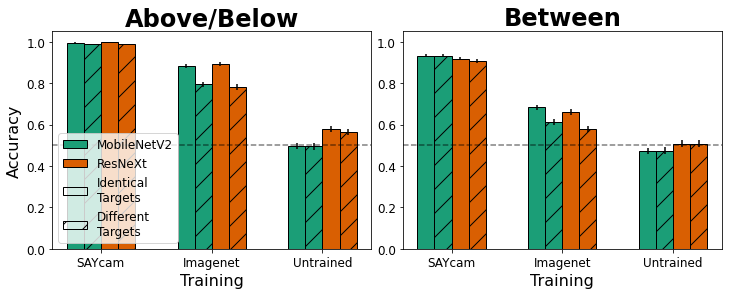

Filtering and grouping by: ['relation', 'dino', 'model', 'n_target_types'] with filter_dict: {'training': 'DINO', 'flip': None, 'rotate_angle': 0, 'same_relation_target_distance_ratio': '1.0', 'transpose': False}


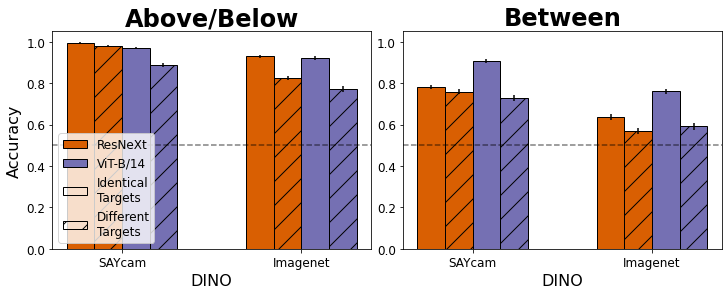

In [8]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'],
        flip=None, dino=None, rotate_angle=0, same_relation_target_distance_ratio='1.0'),
    group_bars_by='training', 
    color_bars_by='model', 
    panel_by='relation',
    hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (12, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Above/Below', 'Between'],
    # sup_title='Baseline models, horizontal reference objects',
    legend_ax_index=0,
    legend_loc='lower left',
    subplot_adjust_params=dict(wspace=0.1),
    save_path=f'{PAPER_FIGURE_DIR}/exp1/1a/baseline_models.pdf',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO', 
        flip=None, rotate_angle=0, same_relation_target_distance_ratio='1.0'),
    group_bars_by='dino', 
    color_bars_by='model', 
    panel_by='relation',
    hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (12, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Above/Below', 'Between'],
    # sup_title='DINO models, horizontal reference objects',
    legend_ax_index=0,
    legend_loc='lower left',
    subplot_adjust_params=dict(wspace=0.1),
    save_path=f'{PAPER_FIGURE_DIR}/exp1/1b/dino_models.pdf',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [9]:
import itertools
from scipy.stats import ttest_rel

TEST_FIELD = 'training'

filter_dict = dict(training=['ImageNet', 'saycam(S)'], flip=None, dino=None, rotate_angle=0)
for k, v in FILTER_DICT_DEFAULT_VALUES.items():
    if k not in filter_dict:
        filter_dict[k] = v

baseline_df = filter_and_group(combined_df, filter_dict, [])

test_field_values = baseline_df[TEST_FIELD].unique()
accuracies_by_dino_dataset = defaultdict(list)

for model, relation, n_target_types in itertools.product(baseline_df.model.unique(), baseline_df.relation.unique(), baseline_df.n_target_types.unique()):
    row_filter = (baseline_df.model == model) & (baseline_df.relation == relation) & (baseline_df.n_target_types == n_target_types) 
    mini_df = baseline_df[row_filter]

    # print(mini_df.shape)
    # print(mini_df.head())

    # if len(mini_df) != (2 * baseline_df.example_index.unique().shape[0]):
    #     print(f'WARNING: {model} {relation} {n_target_types} has unexpected shape: {mini_df.shape}')
    #     break

    mini_groupby_df = mini_df.groupby(TEST_FIELD).acc_mean.mean()

    for test_field_value in test_field_values:
        accuracies_by_dino_dataset[test_field_value].append(mini_groupby_df[test_field_value])


ttest_rel(accuracies_by_dino_dataset[test_field_values[0]], accuracies_by_dino_dataset[test_field_values[1]])


Ttest_relResult(statistic=-7.448235948711892, pvalue=0.00014343276890631517)

In [10]:
import itertools
from scipy.stats import ttest_rel

TEST_FIELD = 'dino'

filter_dict = dict(training='DINO', flip=None)
for k, v in FILTER_DICT_DEFAULT_VALUES.items():
    if k not in filter_dict:
        filter_dict[k] = v

baseline_df = filter_and_group(combined_df, filter_dict, [])

test_field_values = baseline_df[TEST_FIELD].unique()
accuracies_by_dino_dataset = defaultdict(list)

for model, relation, n_target_types in itertools.product(baseline_df.model.unique(), baseline_df.relation.unique(), baseline_df.n_target_types.unique()):
    row_filter = (baseline_df.model == model) & (baseline_df.relation == relation) & (baseline_df.n_target_types == n_target_types) 
    mini_df = baseline_df[row_filter]

    # print(mini_df.shape)
    # print(mini_df.head())

    # if len(mini_df) != (2 * baseline_df.example_index.unique().shape[0]):
    #     print(f'WARNING: {model} {relation} {n_target_types} has unexpected shape: {mini_df.shape}')
    #     break

    mini_groupby_df = mini_df.groupby(TEST_FIELD).acc_mean.mean()

    for test_field_value in test_field_values:
        accuracies_by_dino_dataset[test_field_value].append(mini_groupby_df[test_field_value])


ttest_rel(accuracies_by_dino_dataset[test_field_values[0]], accuracies_by_dino_dataset[test_field_values[1]])


Ttest_relResult(statistic=7.512138545183285, pvalue=0.00013590970867011898)

In [11]:
def agg_stds(stds: pd.Series, in_factor: float = 1.0, out_factor: float = 1.0):
    return np.sqrt(((stds * in_factor) ** 2).mean()) / out_factor 


gb = filter_and_group(combined_df, dict(training=['random', 'ImageNet', 'saycam(S)'],
            flip=None, dino=None, rotate_angle=0, same_relation_target_distance_ratio='1.0'),
            ['training', 'model', 'relation'])

# gb[['acc_std']].agg(agg_stds)

# gb[['acc_sem']].agg(agg_stds, in_factor=32, out_factor=32)

# gb[['acc_std']].agg(agg_stds, in_factor=1, out_factor=32)

gb[['acc_sem']].agg(max)

acc_sem
training  model     relation             
ImageNet  mobilenet above_below  0.013929
                    between      0.015625
          resnext   above_below  0.013834
                    between      0.015611
random    mobilenet above_below  0.015625
                    between      0.015623
          resnext   above_below  0.015625
                    between      0.015625
saycam(S) mobilenet above_below  0.006861
                    between      0.010159
          resnext   above_below  0.005599
                    between      0.011461

Filtering and grouping by: ['model', 'training', 'relation'] with filter_dict: {'training': ['random', 'ImageNet', 'saycam(S)'], 'flip': None, 'dino': None, 'rotate_angle': 0, 'same_relation_target_distance_ratio': '1.0', 'transpose': False}
Filtering and grouping by: ['model', 'training', 'n_target_types'] with filter_dict: {'training': ['random', 'ImageNet', 'saycam(S)'], 'flip': None, 'dino': None, 'rotate_angle': 0, 'same_relation_target_distance_ratio': '1.0', 'transpose': False}


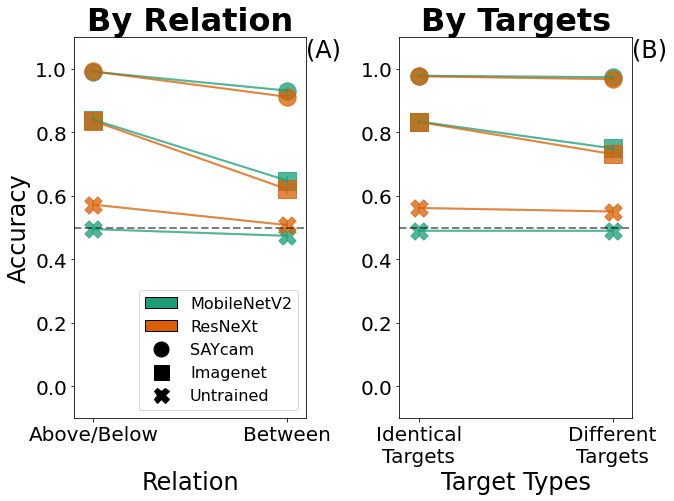

Filtering and grouping by: ['model', 'dino', 'relation'] with filter_dict: {'training': 'DINO', 'flip': None, 'rotate_angle': 0, 'same_relation_target_distance_ratio': '1.0', 'transpose': False}
Filtering and grouping by: ['model', 'dino', 'n_target_types'] with filter_dict: {'training': 'DINO', 'flip': None, 'rotate_angle': 0, 'same_relation_target_distance_ratio': '1.0', 'transpose': False}


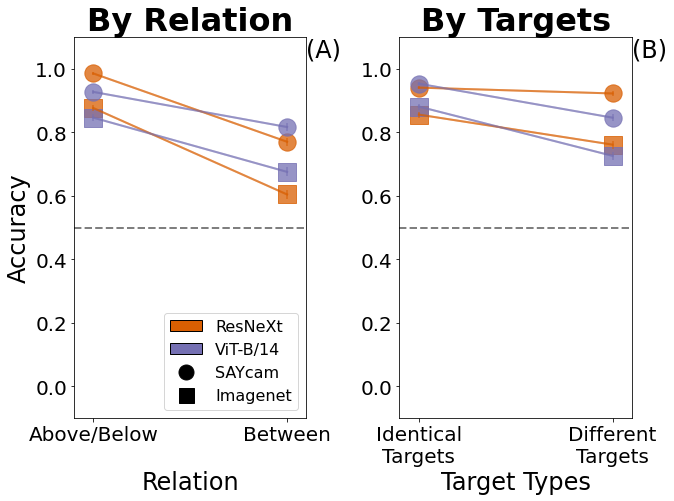

In [12]:
baseline_panel_dicts = [
    defaultdict(lambda: None, dict(
        filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'],
            flip=None, dino=None, rotate_angle=0, same_relation_target_distance_ratio='1.0'),
        marker_by='training', 
        color_by='model', 
        compare_by='relation', 
        title='By Relation')
    ),

    defaultdict(lambda: None, dict(
        filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'],
            flip=None, dino=None, rotate_angle=0, same_relation_target_distance_ratio='1.0'),
        marker_by='training', 
        color_by='model', 
        compare_by='n_target_types',
        title='By Targets')
    ),
]

multiple_paired_scatter_plots(
    combined_df,
    baseline_panel_dicts,
    xlim=(-0.1, 1.1),
    ylim=(-0.1, 1.1),
    legend_ax_index=0,
    legend_loc='lower right',
    title_kwargs=dict(fontweight='bold'),
    text_kwargs=dict(fontsize=24),
    subplot_adjust_params=dict(wspace=0.4,),
    save_path=f'{PAPER_FIGURE_DIR}/exp1/1a/baseline_models_pair_plot.pdf',
)


dino_panel_dicts = [
    defaultdict(lambda: None, dict(
        filter_dict=dict(training='DINO', flip=None, rotate_angle=0, same_relation_target_distance_ratio='1.0'),
        marker_by='dino', 
        color_by='model', 
        compare_by='relation', 
        title='By Relation')
    ),

    defaultdict(lambda: None, dict(
        filter_dict=dict(training='DINO', flip=None, rotate_angle=0, same_relation_target_distance_ratio='1.0'),
        marker_by='dino', 
        color_by='model', 
        compare_by='n_target_types',
        title='By Targets')
    ),
]

multiple_paired_scatter_plots(
    combined_df,
    dino_panel_dicts,
    xlim=(-0.1, 1.1),
    ylim=(-0.1, 1.1),
    legend_ax_index=0,
    legend_loc='lower right',
    title_kwargs=dict(fontweight='bold'),
    text_kwargs=dict(fontsize=24),
    subplot_adjust_params=dict(wspace=0.4,),
    save_path=f'{PAPER_FIGURE_DIR}/exp1/1b/dino_models_pair_plot.pdf',
)





Filtering and grouping by: ['model', 'training', 'relation'] with filter_dict: {'training': ['random', 'ImageNet', 'saycam(S)'], 'flip': None, 'dino': None, 'rotate_angle': 0, 'same_relation_target_distance_ratio': '1.0', 'transpose': False}
Filtering and grouping by: ['model', 'training', 'n_target_types'] with filter_dict: {'training': ['random', 'ImageNet', 'saycam(S)'], 'flip': None, 'dino': None, 'rotate_angle': 0, 'same_relation_target_distance_ratio': '1.0', 'transpose': False}
Filtering and grouping by: ['model', 'training'] with filter_dict: {'training': ['ImageNet', 'saycam(S)'], 'flip': None, 'dino': None, 'rotate_angle': 0, 'same_relation_target_distance_ratio': '1.0', 'transpose': False}


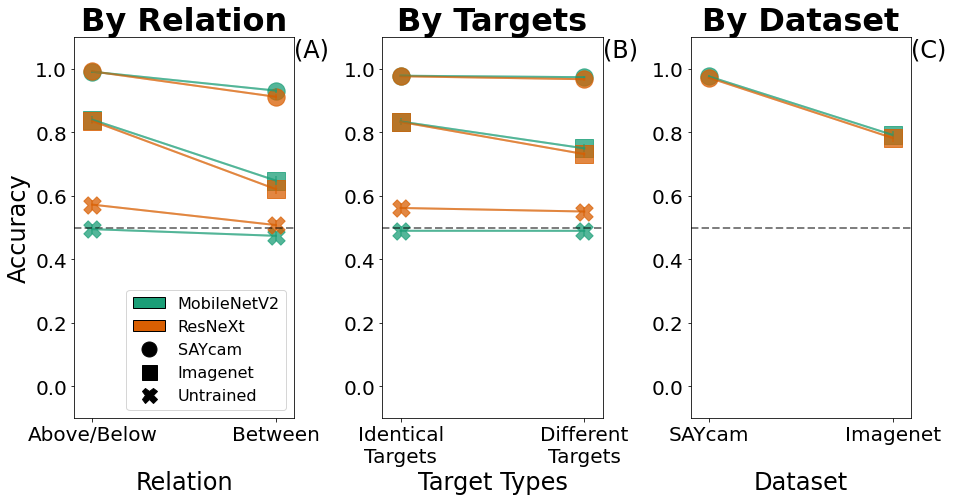

Filtering and grouping by: ['model', 'dino', 'relation'] with filter_dict: {'training': 'DINO', 'flip': None, 'rotate_angle': 0, 'same_relation_target_distance_ratio': '1.0', 'transpose': False}
Filtering and grouping by: ['model', 'dino', 'n_target_types'] with filter_dict: {'training': 'DINO', 'flip': None, 'rotate_angle': 0, 'same_relation_target_distance_ratio': '1.0', 'transpose': False}
Filtering and grouping by: ['model', 'dino'] with filter_dict: {'training': 'DINO', 'flip': None, 'rotate_angle': 0, 'same_relation_target_distance_ratio': '1.0', 'transpose': False}


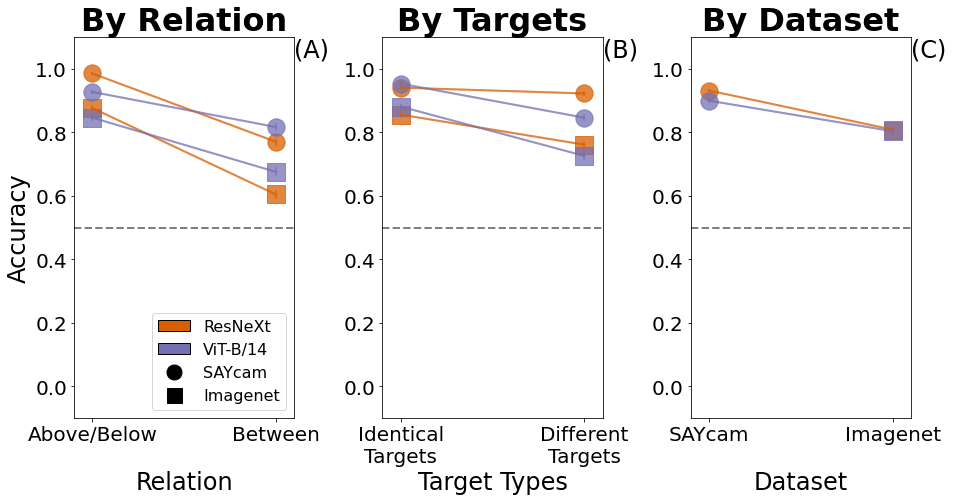

In [13]:
baseline_panel_dicts = [
    defaultdict(lambda: None, dict(
        filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'],
            flip=None, dino=None, rotate_angle=0, same_relation_target_distance_ratio='1.0'),
        marker_by='training', 
        color_by='model', 
        compare_by='relation', 
        title='By Relation')
    ),

    defaultdict(lambda: None, dict(
        filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'],
            flip=None, dino=None, rotate_angle=0, same_relation_target_distance_ratio='1.0'),
        marker_by='training', 
        color_by='model', 
        compare_by='n_target_types',
        title='By Targets')
    ),

    defaultdict(lambda: None, dict(
        filter_dict=dict(training=['ImageNet', 'saycam(S)'],
            flip=None, dino=None, rotate_angle=0, same_relation_target_distance_ratio='1.0'),
        marker_by='training', 
        color_by='model', 
        compare_by='training',
        xlabel='Dataset',
        title='By Dataset')
    ),
]

multiple_paired_scatter_plots(
    combined_df,
    baseline_panel_dicts,
    xlim=(-0.1, 1.1),
    ylim=(-0.1, 1.1),
    legend_ax_index=0,
    legend_loc='lower right',
    title_kwargs=dict(fontweight='bold'),
    text_kwargs=dict(fontsize=24),
    subplot_adjust_params=dict(wspace=0.4,),
    save_path=f'{PAPER_FIGURE_DIR}/exp1/1a/baseline_models_pair_plot_with_dataset_panel.pdf',
)


dino_panel_dicts = [
    defaultdict(lambda: None, dict(
        filter_dict=dict(training='DINO', flip=None, rotate_angle=0, same_relation_target_distance_ratio='1.0'),
        marker_by='dino', 
        color_by='model', 
        compare_by='relation', 
        title='By Relation')
    ),

    defaultdict(lambda: None, dict(
        filter_dict=dict(training='DINO', flip=None, rotate_angle=0, same_relation_target_distance_ratio='1.0'),
        marker_by='dino', 
        color_by='model', 
        compare_by='n_target_types',
        title='By Targets')
    ),

    defaultdict(lambda: None, dict(
        filter_dict=dict(training='DINO', flip=None, rotate_angle=0, same_relation_target_distance_ratio='1.0'),
        marker_by='dino', 
        color_by='model', 
        compare_by='dino',
        xlabel='Dataset',
        title='By Dataset')
    ),
]

multiple_paired_scatter_plots(
    combined_df,
    dino_panel_dicts,
    xlim=(-0.1, 1.1),
    ylim=(-0.1, 1.1),
    legend_ax_index=0,
    legend_loc='lower right',
    title_kwargs=dict(fontweight='bold'),
    text_kwargs=dict(fontsize=24),
    subplot_adjust_params=dict(wspace=0.4,),
    save_path=f'{PAPER_FIGURE_DIR}/exp1/1b/dino_models_pair_plot_with_dataset_panel.pdf',
)





In [14]:
from scipy.stats import ttest_rel

dino_df = filter_and_group(combined_df, dict(training='DINO', flip=None, rotate_angle=0, same_relation_target_distance_ratio='1.0'), [])


dino_datasets = dino_df.dino.unique()
accuracies_by_dino = defaultdict(list)

for model, condition, relation, n_target_types, n_habituation_stimuli in itertools.product(dino_df.model.unique(), dino_df.condition.unique(), dino_df.relation.unique(), dino_df.n_target_types.unique(), dino_df.n_habituation_stimuli.unique()):
    row_filter = (dino_df.model == model) & (dino_df.condition == condition) & (dino_df.relation == relation) & (dino_df.n_target_types == n_target_types) & (dino_df.n_habituation_stimuli == n_habituation_stimuli)
    if relation == 'above_below':
        row_filter = row_filter & (dino_df.above_below_type == 'one_reference')

    mini_df = dino_df[row_filter]
    if len(mini_df) > 2:
        print(f'WARNING: {model} {condition} {relation} has more than 2 values')
        break

    for dino_dataset in dino_datasets:
        accuracies_by_dino[dino_dataset].append(mini_df[mini_df.dino == dino_dataset].acc_mean.values[0])


ttest_rel(accuracies_by_dino['saycam(S)'], accuracies_by_dino['ImageNet'])


Ttest_relResult(statistic=12.797139190372409, pvalue=6.321346941852217e-17)

In [16]:
table_1a = generate_mini_results_table(combined_df, filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'],
        flip=None, dino=None, rotate_angle=0, same_relation_target_distance_ratio='1.0'), group_by_fields=['training', 'model', 'relation', 'n_target_types'],
        tablefmt='latex_raw', df_output_path='./table_1a_df.csv')

print(table_1a)


table_1b = generate_mini_results_table(combined_df, dict(training='DINO', flip=None, rotate_angle=0, same_relation_target_distance_ratio='1.0'), group_by_fields=['dino', 'model', 'relation', 'n_target_types'],
        tablefmt='latex_raw', df_output_path='./table_1b_df.csv')

print(table_1b)

('\\begin{tabular}{llllllrr}\n\\hline\n training   & model     & above_below-1   & above_below-2   & between-1       & between-2       &   Mean diff by relation &   Mean diff by targets \\\\\n\\hline\n random     & mobilenet & $0.50 \\pm 0.02$ & $0.49 \\pm 0.02$ & $0.47 \\pm 0.02$ & $0.47 \\pm 0.02$ &                    0.02 &                  -0    \\\\\n random     & resnext   & $0.58 \\pm 0.02$ & $0.56 \\pm 0.02$ & $0.51 \\pm 0.02$ & $0.51 \\pm 0.02$ &                    0.06 &                   0.01 \\\\\n ImageNet   & mobilenet & $0.88 \\pm 0.01$ & $0.80 \\pm 0.01$ & $0.68 \\pm 0.01$ & $0.61 \\pm 0.01$ &                    0.19 &                   0.08 \\\\\n ImageNet   & resnext   & $0.89 \\pm 0.01$ & $0.78 \\pm 0.01$ & $0.66 \\pm 0.01$ & $0.58 \\pm 0.02$ &                    0.22 &                   0.09 \\\\\n saycam(S)  & mobilenet & $0.99 \\pm 0.00$ & $0.99 \\pm 0.00$ & $0.93 \\pm 0.01$ & $0.93 \\pm 0.01$ &                    0.06 &                   0    \\\\\n saycam(S)  & 

## Experiment 1 appendix plots

Filtering and grouping by: ['relation', 'training', 'model', 'n_target_types'] with filter_dict: {'training': ['ImageNet', 'saycam(S)'], 'flip': None, 'dino': None, 'condition': 'different_shapes', 'rotate_angle': 0, 'same_relation_target_distance_ratio': '1.0', 'transpose': False}


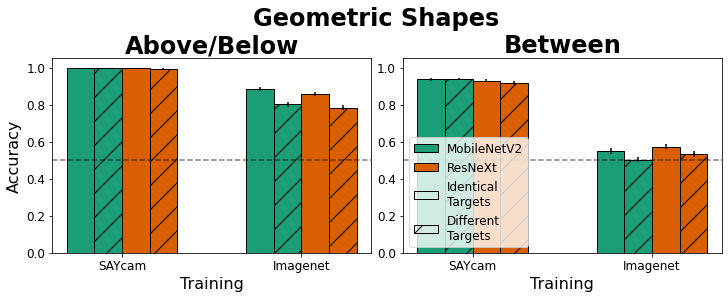

Filtering and grouping by: ['relation', 'training', 'model', 'n_target_types'] with filter_dict: {'training': ['ImageNet', 'saycam(S)'], 'flip': None, 'dino': None, 'condition': 'split_text', 'rotate_angle': 0, 'same_relation_target_distance_ratio': '1.0', 'transpose': False}


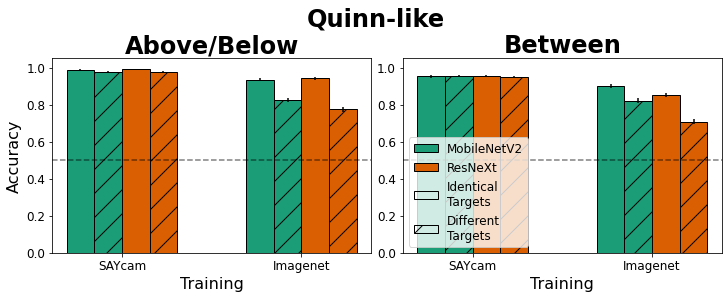

Filtering and grouping by: ['relation', 'training', 'model', 'n_target_types'] with filter_dict: {'training': ['ImageNet', 'saycam(S)'], 'flip': None, 'dino': None, 'condition': 'random_color', 'rotate_angle': 0, 'same_relation_target_distance_ratio': '1.0', 'transpose': False}


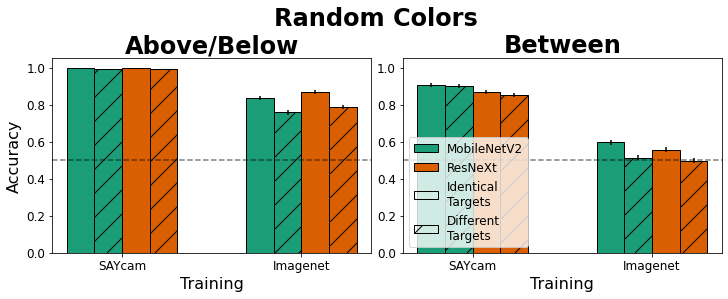

In [17]:
CONDITION_TITLE_MAPPING = {
    'different_shapes': 'Geometric Shapes', 
    'split_text': 'Quinn-like', 
    'random_color': 'Random Colors',
}

for condition in combined_df.condition.unique():
    multiple_bar_plots(combined_df,
        # what and how to plot arguments
        filter_dict=dict(training=['ImageNet', 'saycam(S)'],
            flip=None, dino=None, condition=condition, 
            rotate_angle=0, same_relation_target_distance_ratio='1.0'),
        group_bars_by='training', 
        color_bars_by='model', 
        panel_by='relation',
        hatch_bars_by='n_target_types',
        # plot style arguments
        figsize = (12, 4),
        layout = (1, 2),
        title_kwargs=dict(fontweight='bold'),
        # panel_titles=['Different Shapes', 'Split Text', 'Random Color'],
        panel_titles=['Above/Below', 'Between'],
        sup_title=CONDITION_TITLE_MAPPING[condition],
        legend_ax_index=1,
        legend_loc='lower left',
        subplot_adjust_params=dict(wspace=0.1, top=0.8),
        save_path=f'{PAPER_FIGURE_DIR}/appendix/exp1/1a/baseline_{condition}.pdf',
        )


Filtering and grouping by: ['model', 'training', 'relation'] with filter_dict: {'training': ['random', 'ImageNet', 'saycam(S)'], 'condition': 'different_shapes', 'flip': None, 'dino': None, 'rotate_angle': 0, 'same_relation_target_distance_ratio': '1.0', 'transpose': False}
Filtering and grouping by: ['model', 'training', 'n_target_types'] with filter_dict: {'training': ['random', 'ImageNet', 'saycam(S)'], 'condition': 'different_shapes', 'flip': None, 'dino': None, 'rotate_angle': 0, 'same_relation_target_distance_ratio': '1.0', 'transpose': False}


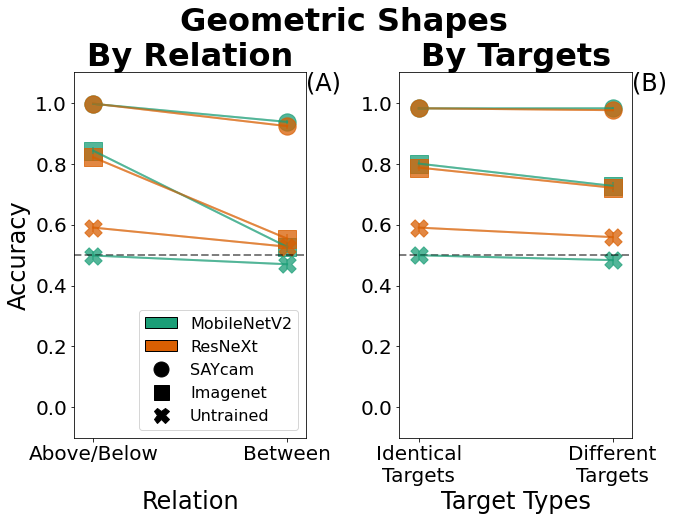

Filtering and grouping by: ['model', 'training', 'relation'] with filter_dict: {'training': ['random', 'ImageNet', 'saycam(S)'], 'condition': 'split_text', 'flip': None, 'dino': None, 'rotate_angle': 0, 'same_relation_target_distance_ratio': '1.0', 'transpose': False}
Filtering and grouping by: ['model', 'training', 'n_target_types'] with filter_dict: {'training': ['random', 'ImageNet', 'saycam(S)'], 'condition': 'split_text', 'flip': None, 'dino': None, 'rotate_angle': 0, 'same_relation_target_distance_ratio': '1.0', 'transpose': False}


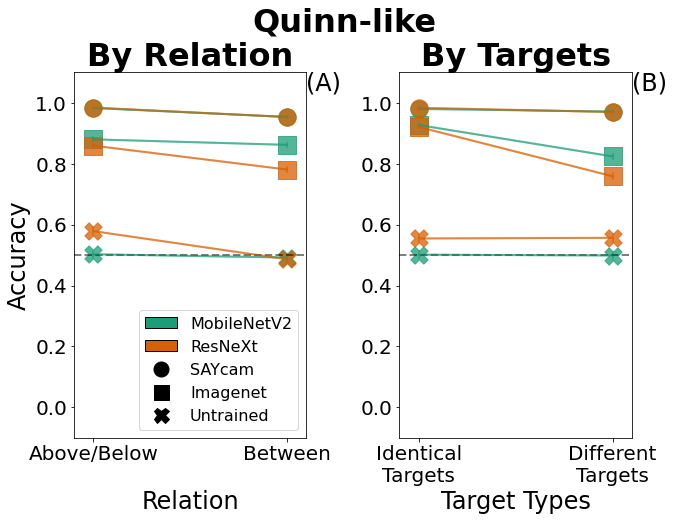

Filtering and grouping by: ['model', 'training', 'relation'] with filter_dict: {'training': ['random', 'ImageNet', 'saycam(S)'], 'condition': 'random_color', 'flip': None, 'dino': None, 'rotate_angle': 0, 'same_relation_target_distance_ratio': '1.0', 'transpose': False}
Filtering and grouping by: ['model', 'training', 'n_target_types'] with filter_dict: {'training': ['random', 'ImageNet', 'saycam(S)'], 'condition': 'random_color', 'flip': None, 'dino': None, 'rotate_angle': 0, 'same_relation_target_distance_ratio': '1.0', 'transpose': False}


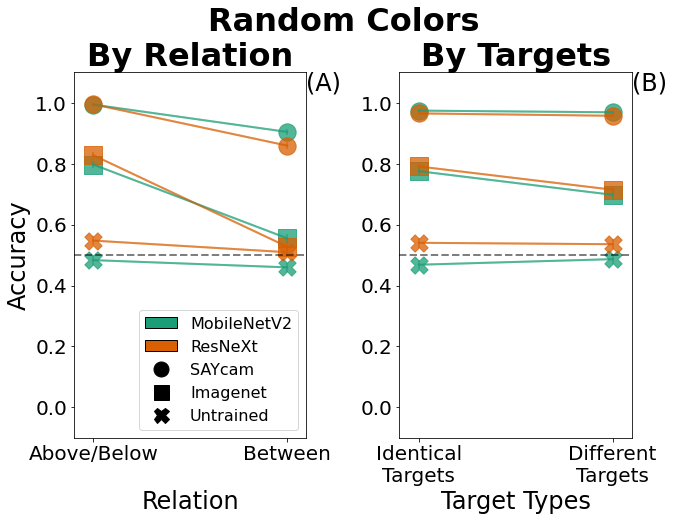

In [18]:
CONDITION_TITLE_MAPPING = {
    'different_shapes': 'Geometric Shapes', 
    'split_text': 'Quinn-like', 
    'random_color': 'Random Colors',
}

for condition in combined_df.condition.unique():
    baseline_panel_dicts = [
        defaultdict(lambda: None, dict(
            filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'], condition=condition,
                flip=None, dino=None, rotate_angle=0, same_relation_target_distance_ratio='1.0'),
            marker_by='training', 
            color_by='model', 
            compare_by='relation', 
            title='By Relation')
        ),

        defaultdict(lambda: None, dict(
            filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'], condition=condition,
                flip=None, dino=None, rotate_angle=0, same_relation_target_distance_ratio='1.0'),
            marker_by='training', 
            color_by='model', 
            compare_by='n_target_types',
            title='By Targets')
        ),
    ]

    multiple_paired_scatter_plots(
        combined_df,
        baseline_panel_dicts,
        xlim=(-0.1, 1.1),
        ylim=(-0.1, 1.1),
        legend_ax_index=0,
        legend_loc='lower right',
        title_kwargs=dict(fontweight='bold'),
        text_kwargs=dict(fontsize=24),
        sup_title=CONDITION_TITLE_MAPPING[condition],
        subplot_adjust_params=dict(wspace=0.4,top=0.85),
        save_path=f'{PAPER_FIGURE_DIR}/appendix/exp1/1a/baseline_{condition}_pair_plot.pdf',
    )


Filtering and grouping by: ['above_below_type', 'training', 'model', 'n_target_types'] with filter_dict: {'training': ['ImageNet', 'saycam(S)'], 'relation': 'above_below', 'flip': None, 'dino': None, 'rotate_angle': 0, 'same_relation_target_distance_ratio': '1.0', 'transpose': False}


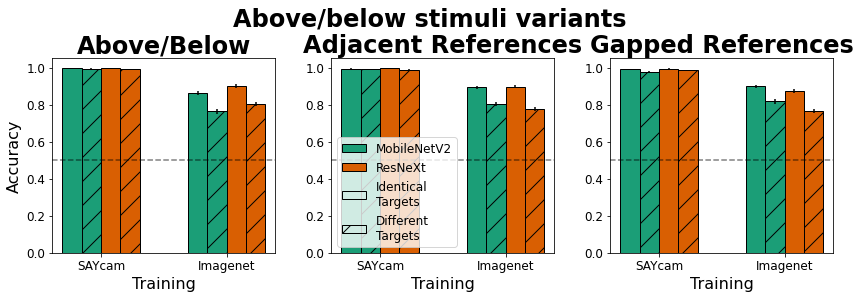

In [19]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training=['ImageNet', 'saycam(S)'], 
        relation='above_below', flip=None, dino=None, 
        rotate_angle=0, same_relation_target_distance_ratio='1.0'),
    group_bars_by='training', 
    color_bars_by='model', 
    panel_by='above_below_type',
    hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (14, 4),
    layout = (1, 3),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Above/Below', 'Adjacent References', 'Gapped References'],
    sup_title='Above/below stimuli variants',
    legend_ax_index=1,
    legend_loc='lower left',
    save_path=f'{PAPER_FIGURE_DIR}/appendix/exp1/1a/baseline_above_below_variants.pdf',
    subplot_adjust_params=dict(wspace=0.25, top=0.8),
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

Filtering and grouping by: ['model', 'training', 'n_target_types'] with filter_dict: {'training': ['random', 'ImageNet', 'saycam(S)'], 'above_below_type': 'one_reference', 'flip': None, 'dino': None, 'rotate_angle': 0, 'same_relation_target_distance_ratio': '1.0', 'transpose': False}
Filtering and grouping by: ['model', 'training', 'n_target_types'] with filter_dict: {'training': ['random', 'ImageNet', 'saycam(S)'], 'above_below_type': 'adjacent_references', 'flip': None, 'dino': None, 'rotate_angle': 0, 'same_relation_target_distance_ratio': '1.0', 'transpose': False}
Filtering and grouping by: ['model', 'training', 'n_target_types'] with filter_dict: {'training': ['random', 'ImageNet', 'saycam(S)'], 'above_below_type': 'gapped_references', 'flip': None, 'dino': None, 'rotate_angle': 0, 'same_relation_target_distance_ratio': '1.0', 'transpose': False}


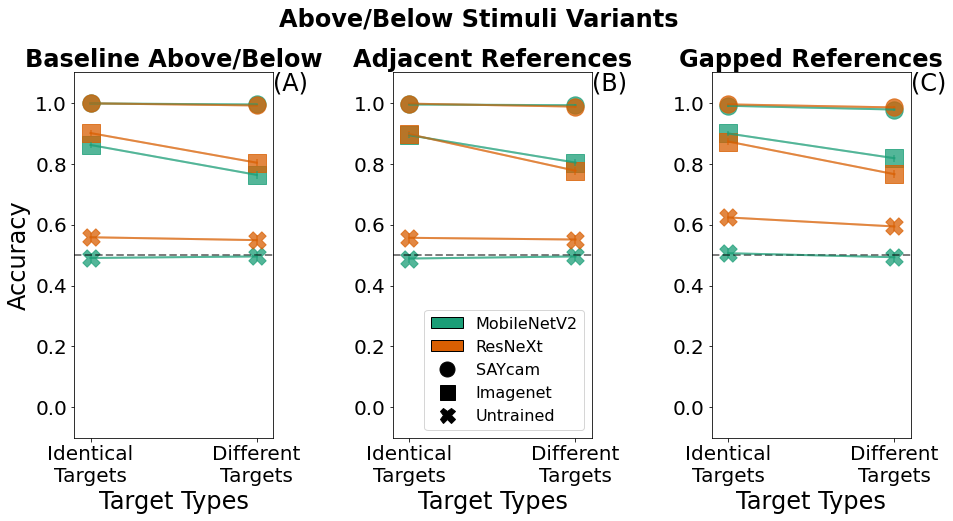

In [20]:
above_below_types = ['one_reference', 'adjacent_references', 'gapped_references']
panel_tiles = ['Baseline Above/Below', 'Adjacent References', 'Gapped References']
    

above_below_variant_panel_dicts = [
    defaultdict(lambda: None, dict(
        filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'], above_below_type=above_below_types[i],
            flip=None, dino=None, rotate_angle=0, same_relation_target_distance_ratio='1.0'),
        marker_by='training', 
        color_by='model', 
        compare_by='n_target_types', 
        title=panel_tiles[i])
    )
    for i in range(len(above_below_types)) 
]

multiple_paired_scatter_plots(
    combined_df,
    above_below_variant_panel_dicts,
    xlim=(-0.1, 1.1),
    ylim=(-0.1, 1.1),
    legend_ax_index=1,
    legend_loc='lower right',
    title_kwargs=dict(fontweight='bold', fontsize=24),
    text_kwargs=dict(fontsize=24),
    sup_title='Above/Below Stimuli Variants',
    subplot_adjust_params=dict(wspace=0.6, top=0.85),
    save_path=f'{PAPER_FIGURE_DIR}/appendix/exp1/1a/baseline_above_below_variants_pair_plot.pdf',
)


Filtering and grouping by: ['relation', 'training', 'model', 'n_habituation_stimuli'] with filter_dict: {'training': ['random', 'ImageNet', 'saycam(S)'], 'flip': None, 'dino': None, 'rotate_angle': 0, 'same_relation_target_distance_ratio': '1.0', 'n_target_types': 1, 'transpose': False}


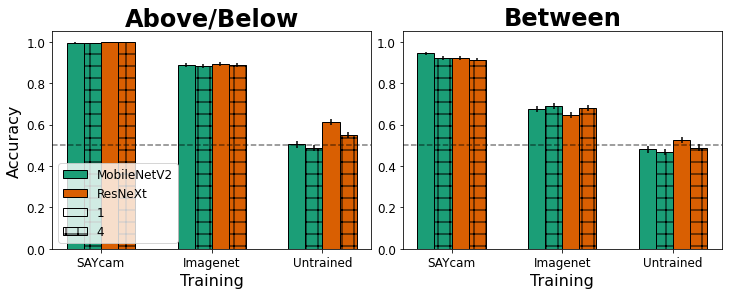

Filtering and grouping by: ['relation', 'dino', 'model', 'n_habituation_stimuli'] with filter_dict: {'training': 'DINO', 'flip': None, 'rotate_angle': 0, 'same_relation_target_distance_ratio': '1.0', 'n_target_types': 1, 'transpose': False}


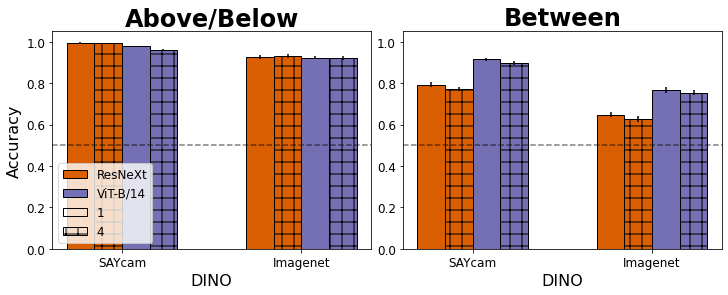

In [21]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'], 
        flip=None, dino=None, rotate_angle=0, same_relation_target_distance_ratio='1.0', n_target_types=1),
    group_bars_by='training', 
    color_bars_by='model', 
    panel_by='relation',
    hatch_bars_by='n_habituation_stimuli',
    # plot style arguments
    figsize = (12, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Above/Below', 'Between'],
    # sup_title='Adding additional habituation stimuli',
    legend_ax_index=0,
    legend_loc='lower left',
    subplot_adjust_params=dict(wspace=0.1),
    save_path=f'{PAPER_FIGURE_DIR}/appendix/exp1/1a/baseline_additional_habituation_stimuli.pdf',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )


multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO', flip=None, rotate_angle=0, same_relation_target_distance_ratio='1.0', n_target_types=1),
    group_bars_by='dino', 
    color_bars_by='model', 
    panel_by='relation',
    # group_bars_by='model', 
    # color_bars_by='dino', 
    # panel_by='relation',
    hatch_bars_by='n_habituation_stimuli',
    # plot style arguments
    figsize = (12, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Above/Below', 'Between'],
    # sup_title='Adding additional habituation stimuli',
    legend_ax_index=0,
    legend_loc='lower left',
    subplot_adjust_params=dict(wspace=0.1),
    save_path=f'{PAPER_FIGURE_DIR}/appendix/exp1/1a/dino_additional_habituation_stimuli.pdf',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

Filtering and grouping by: ['model', 'training', 'n_habituation_stimuli'] with filter_dict: {'training': ['random', 'ImageNet', 'saycam(S)'], 'flip': None, 'dino': None, 'rotate_angle': 0, 'same_relation_target_distance_ratio': '1.0', 'transpose': False}
Filtering and grouping by: ['model', 'dino', 'n_habituation_stimuli'] with filter_dict: {'training': 'DINO', 'flip': None, 'rotate_angle': 0, 'same_relation_target_distance_ratio': '1.0', 'transpose': False}


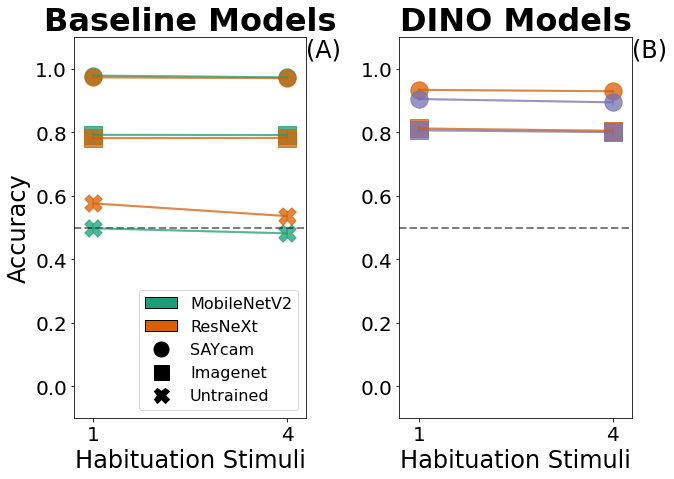

In [22]:
n_habituation_stimuli_panel_dicts = [
    defaultdict(lambda: None, dict(
        filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'],
            flip=None, dino=None, rotate_angle=0, same_relation_target_distance_ratio='1.0'),
        marker_by='training', 
        color_by='model', 
        compare_by='n_habituation_stimuli',
        title='Baseline Models')
    ),

     defaultdict(lambda: None, dict(
        filter_dict=dict(training='DINO', flip=None, rotate_angle=0, same_relation_target_distance_ratio='1.0'),
        marker_by='dino', 
        color_by='model', 
        compare_by='n_habituation_stimuli',
        title='DINO Models')
    ),
]

multiple_paired_scatter_plots(
    combined_df,
    n_habituation_stimuli_panel_dicts,
    xlim=(-0.1, 1.1),
    ylim=(-0.1, 1.1),
    legend_ax_index=0,
    legend_loc='lower right',
    title_kwargs=dict(fontweight='bold'),
    text_kwargs=dict(fontsize=24),
    subplot_adjust_params=dict(wspace=0.4,),
    save_path=f'{PAPER_FIGURE_DIR}/appendix/exp1/1a/additional_habituation_stimuli_pair_plot.pdf',
)

## Experiment 1c

Filtering and grouping by: ['relation', 'training', 'model', 'n_target_types'] with filter_dict: {'training': ['random', 'ImageNet', 'saycam(S)'], 'flip': None, 'dino': None, 'rotate_angle': 90, 'same_relation_target_distance_ratio': '1.0', 'transpose': False}


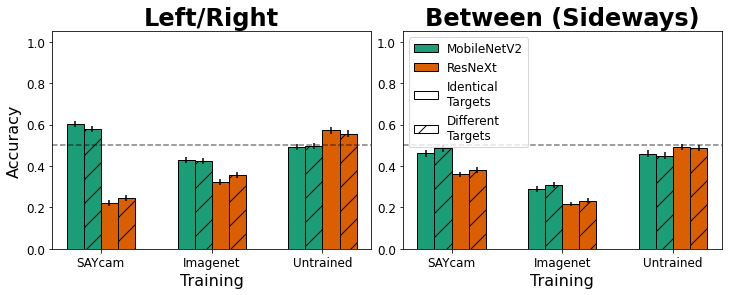

Filtering and grouping by: ['relation', 'dino', 'model', 'n_target_types'] with filter_dict: {'training': 'DINO', 'flip': None, 'rotate_angle': 90, 'same_relation_target_distance_ratio': '1.0', 'transpose': False}


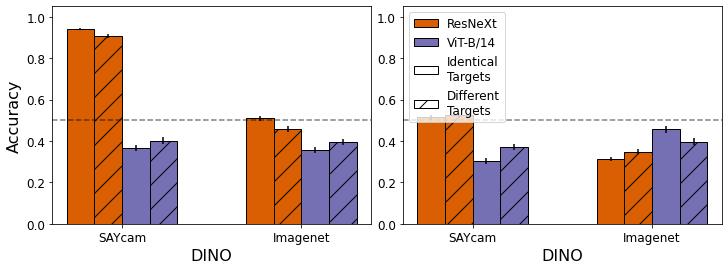

In [23]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'],
        flip=None, dino=None, rotate_angle=90, same_relation_target_distance_ratio='1.0'),
    group_bars_by='training', 
    color_bars_by='model', 
    panel_by='relation',
    hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (12, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Left/Right', 'Between (Sideways)'],
    # sup_title='Baseline models, horizontal reference objects',
    legend_ax_index=1,
    legend_loc='upper left',
    save_path=f'{PAPER_FIGURE_DIR}/exp1/1c/baseline_models_vertical_reference_objects.pdf',
    subplot_adjust_params=dict(wspace=0.1),
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO', flip=None, rotate_angle=90, same_relation_target_distance_ratio='1.0'),
    group_bars_by='dino', 
    color_bars_by='model', 
    panel_by='relation',
    hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (12, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles= ['', ''],  # ['Left/Right', 'Between (Sideways)'],
    # sup_title='DINO models, horizontal reference objects',
    legend_ax_index=1,
    legend_loc='upper left',
    save_path=f'{PAPER_FIGURE_DIR}/exp1/1c/dino_models_vertical_reference_objects.pdf',
    subplot_adjust_params=dict(wspace=0.1),
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

**TODO**: revise these to have one panel for above below and one for between, with 0 degrees on the left and 90 degrees on the right

Layout: (1, 2)
Figsize: (10, 7)
Filtering and grouping by: ['model', 'training', 'rotate_angle'] with filter_dict: {'training': ['random', 'ImageNet', 'saycam(S)'], 'relation': 'above_below', 'flip': None, 'dino': None, 'rotate_angle': [0, 90], 'same_relation_target_distance_ratio': '1.0', 'transpose': False}
Filtering and grouping by: ['model', 'training', 'rotate_angle'] with filter_dict: {'training': ['random', 'ImageNet', 'saycam(S)'], 'relation': 'between', 'flip': None, 'dino': None, 'rotate_angle': [0, 90], 'same_relation_target_distance_ratio': '1.0', 'transpose': False}


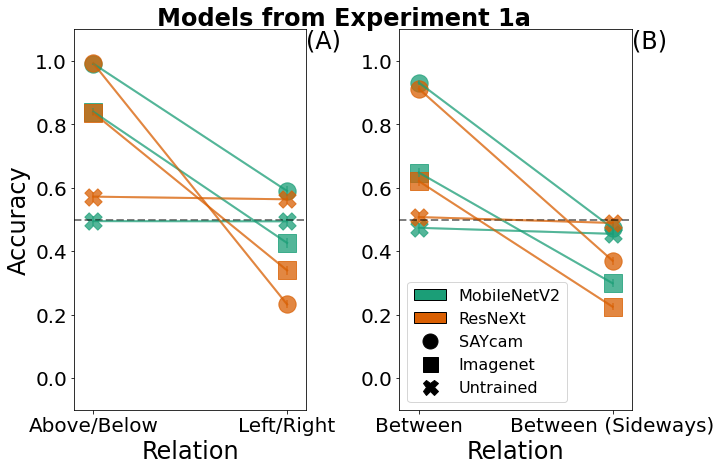

Layout: (1, 2)
Figsize: (10, 7)
Filtering and grouping by: ['model', 'dino', 'rotate_angle'] with filter_dict: {'training': 'DINO', 'relation': 'above_below', 'flip': None, 'rotate_angle': [0, 90], 'same_relation_target_distance_ratio': '1.0', 'transpose': False}
Filtering and grouping by: ['model', 'dino', 'rotate_angle'] with filter_dict: {'training': 'DINO', 'relation': 'between', 'flip': None, 'rotate_angle': [0, 90], 'same_relation_target_distance_ratio': '1.0', 'transpose': False}


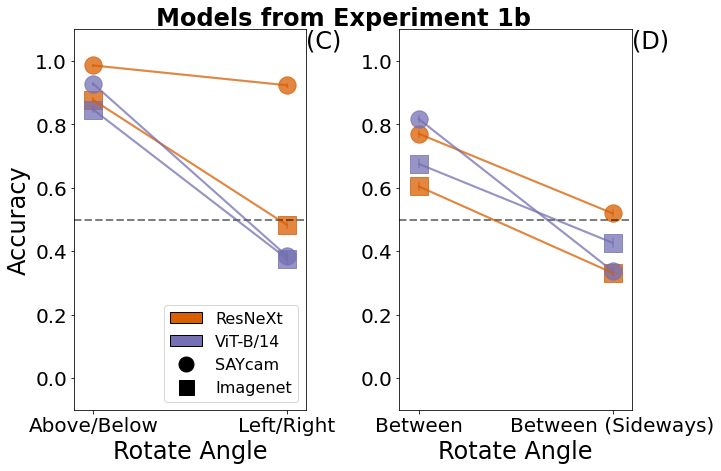

In [23]:
baseline_left_right_panel_dicts = [
    defaultdict(lambda: None, dict(
        filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'], relation='above_below',
            flip=None, dino=None, rotate_angle=[0, 90], same_relation_target_distance_ratio='1.0'),
        marker_by='training', 
        color_by='model', 
        compare_by='rotate_angle', 
        xticklabels=['Above/Below', 'Left/Right'],
        # title='',
        # title=f'{" " * 40}Models from Experiment 1a',
        # title='Exp 1a Models Left/Right',
    )),

    defaultdict(lambda: None, dict(
        filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'], relation='between',
            flip=None, dino=None, rotate_angle=[0, 90], same_relation_target_distance_ratio='1.0'),
        marker_by='training', 
        color_by='model', 
        compare_by='rotate_angle',
        xticklabels=['Between', 'Between (Sideways)'],
        # title='',
        # title='Between (Sideways)'
        # title='1a Models Sideways Between'
    )),
]

multiple_paired_scatter_plots(
    combined_df,
    baseline_left_right_panel_dicts,
    xlim=(-0.1, 1.1),
    ylim=(-0.1, 1.1),
    sup_title='Models from Experiment 1a',
    sup_title_kwargs=dict(y=0.925),
    xlabel='Relation',
    legend_ax_index=1,
    legend_loc='lower left',
    title_kwargs=dict(fontweight='bold', fontsize=24),
    text_kwargs=dict(fontsize=24),
    subplot_adjust_params=dict(wspace=0.4,),
    save_path=f'{PAPER_FIGURE_DIR}/exp1/1c/baseline_models_vertical_reference_objects_pair_plot.pdf',
)


dino_left_right_panel_dicts = [
    defaultdict(lambda: None, dict(
        filter_dict=dict(training='DINO', relation='above_below',
            flip=None, rotate_angle=[0, 90], same_relation_target_distance_ratio='1.0'),
        marker_by='dino', 
        color_by='model', 
        compare_by='rotate_angle', 
        xticklabels=['Above/Below', 'Left/Right'],
        # title='',
        # title=f'{" " * 40}Models from Experiment 1b',
        # title='Exp 1b Models Left/Right',
    )),

    defaultdict(lambda: None, dict(
        filter_dict=dict(training='DINO', relation='between',
            flip=None, rotate_angle=[0, 90], same_relation_target_distance_ratio='1.0'),
        marker_by='dino', 
        color_by='model', 
        compare_by='rotate_angle',
        xticklabels=['Between', 'Between (Sideways)'],
        # title='',
        # title='Between (Sideways)',
        # title='1b Models Sideways Between',
    )),
]


def c_panel_marker_formatter(index: int):
    return f'({chr(ord("C") + index)})'

multiple_paired_scatter_plots(
    combined_df,
    dino_left_right_panel_dicts,
    xlim=(-0.1, 1.1),
    ylim=(-0.1, 1.1),
    sup_title='Models from Experiment 1b',
    sup_title_kwargs=dict(y=0.925),
    legend_ax_index=0,
    legend_loc='lower right',
    panel_marker_formatter=c_panel_marker_formatter,
    title_kwargs=dict(fontweight='bold', fontsize=24),
    text_kwargs=dict(fontsize=24),
    subplot_adjust_params=dict(wspace=0.4,),
    save_path=f'{PAPER_FIGURE_DIR}/exp1/1c/dino_models_vertical_reference_objects_pair_plot.pdf',
)





## Experiment 1d

Filtering and grouping by: ['relation', 'angle_from_horizontal', 'flip'] with filter_dict: {'training': 'saycam(S)-flip', 'flip': ['s', 'h', 'v'], 'dino': None, 'same_relation_target_distance_ratio': '1.0', 'transpose': False}


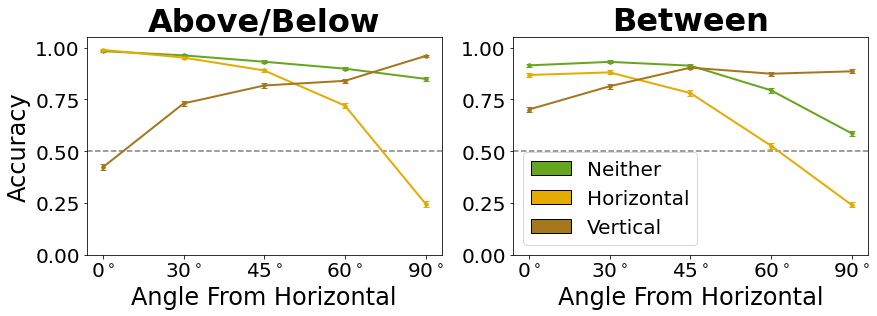

In [60]:
line_kwargs = {k:v for k, v in DEFAULT_LINE_KWARGS.items()}
line_kwargs['markersize'] = 7
line_kwargs['linewidth'] = 2
line_kwargs['capsize'] = 3

xticklabels = [f'${angle}^\\circ$' for angle in combined_df.angle_from_horizontal.unique()]

multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip', flip=['s', 'h', 'v'],
        dino=None, same_relation_target_distance_ratio='1.0'),
    group_bars_by='angle_from_horizontal', 
    color_bars_by='flip', 
    panel_by='relation',
    # plot style arguments
    # figsize = (9, 9),
    # layout = (2, 1),
    figsize = (14, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Above/Below', 'Between'],
    legend_ax_index=1,
    legend_loc='lower left',
    text_kwargs=dict(fontsize=24),
    # sup_title='Effect of flipping angle line plot',
    line_plot=True,
    plot_std=True,
    global_line_kwargs=line_kwargs,
    subplot_adjust_params=dict(wspace=0.2),
    xticklabels=xticklabels,
    # subplot_adjust_params=dict(hspace=0.4),
    save_path=f'{PAPER_FIGURE_DIR}/exp1/1d/flip_angle_line_plot.pdf',
    
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

Filtering and grouping by: ['relation', 'angle_from_horizontal', 'flip'] with filter_dict: {'training': 'saycam(S)-flip', 'flip': ['s', 'h', 'v'], 'dino': None, 'same_relation_target_distance_ratio': '1.0', 'transpose': False}


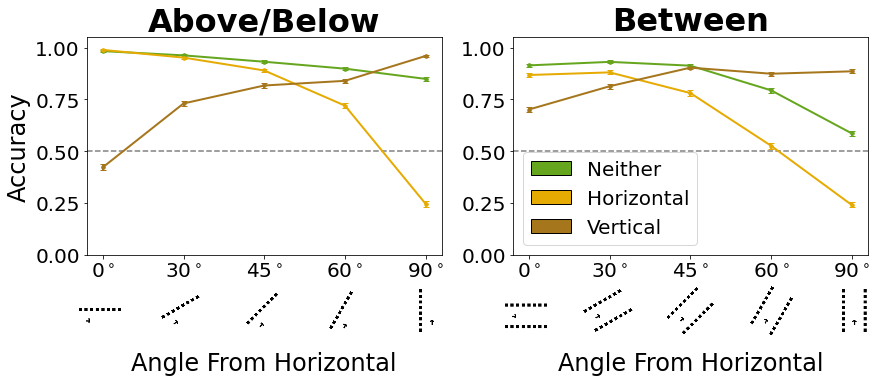

In [61]:
line_kwargs = {k:v for k, v in DEFAULT_LINE_KWARGS.items()}
line_kwargs['markersize'] = 7  # type: ignore
line_kwargs['linewidth'] = 2  # type: ignore
line_kwargs['capsize'] = 3  # type: ignore

xticklabels = [f'${angle}^\\circ$' for angle in combined_df.angle_from_horizontal.unique()]

fig, ax = multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip', flip=['s', 'h', 'v'],  # type: ignore
        dino=None, same_relation_target_distance_ratio='1.0'),  
    group_bars_by='angle_from_horizontal', 
    color_bars_by='flip', 
    panel_by='relation',
    # plot style arguments
    # figsize = (9, 9),
    # layout = (2, 1),
    figsize = (14, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Above/Below', 'Between'],
    legend_ax_index=1,
    legend_loc='lower left',
    text_kwargs=dict(fontsize=24),  # type: ignore
    # sup_title='Effect of flipping angle line plot',
    line_plot=True,
    plot_std=True,
    global_line_kwargs=line_kwargs,  # type: ignore
    subplot_adjust_params=dict(wspace=0.2),
    xticklabels=xticklabels,
    # subplot_adjust_params=dict(hspace=0.4),
    # save_path=f'{PAPER_FIGURE_DIR}/exp1/1d/flip_angle_line_plot.pdf',
    
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    return_fig_and_axes=True,
    )

# TODO: offset from tick position
# TODO: box_alignment?

def add_images_below_ax(ax: plt.Axes, images: typing.List[np.ndarray], zoom: float = 0.3, box_alignment=(0.5, 1.35), labelpad: int = 70):
    tick_labels = ax.xaxis.get_ticklabels()
    
    for i, image in enumerate(images):
        image_box = OffsetImage(image, zoom=zoom)
        ab = AnnotationBbox(image_box, tick_labels[i].get_position(), frameon=False, box_alignment=box_alignment)
        ax.add_artist(ab)
    
    ax.xaxis.labelpad = labelpad

above_below_images = [plt.imread(f'./figures/temp_figures/rotates_and_flips/above_below/{angle}_neither.png') for angle in [0, 30, 45, 60, 90]]
between_images = [plt.imread(f'./figures/temp_figures/rotates_and_flips/between/{angle}_neither.png') for angle in [0, 30, 45, 60, 90]]

add_images_below_ax(ax[0], above_below_images)  # type: ignore
add_images_below_ax(ax[1], between_images)  # type: ignore

save_plot(f'{PAPER_FIGURE_DIR}/exp1/1d/flip_angle_line_plot_with_examples.pdf')

plt.show()

## Previous plots

In [ ]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training=['ImageNet', 'saycam(S)'], above_below_type='one_reference',
        relation='above_below', flip=None, dino=None, 
        rotate_angle=0, same_relation_target_distance_ratio='1.0'),
    group_bars_by='training', 
    color_bars_by='model', 
    panel_by='condition',
    hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (22, 4),
    layout = (1, 3),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Different Shapes', 'Split Text', 'Random Color'],
    sup_title='One reference above/below by stimulus generator',
    legend_ax_index=1,
    legend_loc='lower left',
    save_path='baseline_above_below_one_reference_by_stimulus_generator.png',
    )

multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training=['ImageNet', 'saycam(S)'], above_below_type='adjacent_references',
        relation='above_below', flip=None, dino=None, rotate_angle=0),
    group_bars_by='training', 
    color_bars_by='model', 
    panel_by='condition',
    hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (22, 4),
    layout = (1, 3),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Different Shapes', 'Split Text', 'Random Color'],
    sup_title='Adjacent references above/below by stimulus generator',
    legend_ax_index=1,
    legend_loc='lower left',
    save_path='baseline_above_below_adjacent_references_by_stimulus_generator.png',
    )

multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training=['ImageNet', 'saycam(S)'], above_below_type='gapped_references',
        relation='above_below', flip=None, dino=None, rotate_angle=0),
    group_bars_by='training', 
    color_bars_by='model', 
    panel_by='condition',
    hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (22, 4),
    layout = (1, 3),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Different Shapes', 'Split Text', 'Random Color'],
    sup_title='Gapped references above/below by stimulus generator',
    legend_ax_index=1,
    legend_loc='lower left',
    save_path='baseline_above_below_gapped_references_by_stimulus_generator.png',
    )


In [ ]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training=['ImageNet', 'saycam(S)'], 
        flip=None, dino=None, same_relation_target_distance_ratio='1.0'),
    group_bars_by='rotate_angle', 
    color_bars_by='model', 
    panel_by='relation',
    hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (12, 9),
    layout = (2, 1),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Above/Below', 'Between'],
    legend_ax_index=1,
    legend_loc='upper center',
    sup_title='Baseline, effect of stimulus angle',
    subplot_adjust_params=dict(top=0.9, hspace=0.3),
    save_path='baseline_stimulus_angle.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip', 
        dino=None, relation='above_below', same_relation_target_distance_ratio='1.0'),
    group_bars_by='rotate_angle', 
    color_bars_by='model', 
    panel_by='flip',
    hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (12, 18),
    layout = (4, 1),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['No Flipping', 'Horizontal Only', 'Vertical Only', 'Horizontal and Vertical'],
    legend_ax_index=1,
    legend_loc='upper center',
    sup_title='Effect of flipping angle, above/below',
    subplot_adjust_params=dict(top=0.92, hspace=0.4),
    save_path='stimulus_angle_flipping_above_below.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip', 
        dino=None, relation='between', same_relation_target_distance_ratio='1.0'),
    group_bars_by='rotate_angle', 
    color_bars_by='model', 
    panel_by='flip',
    hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (12, 18),
    layout = (4, 1),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['No Flipping', 'Horizontal Only', 'Vertical Only', 'Horizontal and Vertical'],
    legend_ax_index=1,
    legend_loc='upper center',
    sup_title='Effect of flipping angle, between',
    subplot_adjust_params=dict(top=0.92, hspace=0.4),
    save_path='stimulus_angle_flipping_between.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip', relation='above_below',
        dino=None, same_relation_target_distance_ratio='1.0'),
    group_bars_by='rotate_angle', 
    color_bars_by='flip', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (12, 4),
    # layout = (2, 1),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    legend_ax_index=1,
    legend_loc='lower right',
    sup_title='Flipping models by stimulus angle, above/below',
    subplot_adjust_params=dict(top=0.9, hspace=0.4),
    # legend_kwargs=dict(bbox_to_anchor=(1.23, 0.45)),
    # save_path='stimulus_angle_flipping_coimbined.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip', relation='between',
        dino=None, same_relation_target_distance_ratio='1.0'),
    group_bars_by='rotate_angle', 
    color_bars_by='flip', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (12, 4),
    # layout = (2, 1),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    legend_ax_index=1,
    legend_loc='lower right',
    sup_title='Flipping models by stimulus angle, between',
    subplot_adjust_params=dict(top=0.9, hspace=0.4),
    # legend_kwargs=dict(bbox_to_anchor=(1.23, 0.45)),
    # save_path='stimulus_angle_flipping_coimbined.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip', dino=None, 
        same_relation_target_distance_ratio='1.0', rotate_angle=0),
    group_bars_by='model', 
    color_bars_by='flip', 
    panel_by='relation',
    hatch_bars_by='n_target_types',
    # plot_field='correct',
    # compute_std=True,
    # plot style arguments
    figsize = (10, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Above/Below', 'Between'],
    # panel_titles=f'Flipping models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    sup_title='Flipping models with simple stimuli',
    legend_ax_index=1,
    legend_loc='lower left',
    # legend_kwargs=dict(bbox_to_anchor=(1.3, .375)),
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip', 
        dino=None, same_relation_target_distance_ratio='1.0'),
    group_bars_by='rotate_angle', 
    color_bars_by='flip', 
    panel_by='relation',
    hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (12, 9),
    layout = (2, 1),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Above/Below', 'Between'],
    legend_ax_index=1,
    legend_loc='lower right',
    sup_title='Effect of flipping angle, alternative',
    subplot_adjust_params=dict(top=0.9, hspace=0.4),
    save_path='stimulus_angle_flipping_coimbined.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip', 
        dino=None, same_relation_target_distance_ratio='1.0'),
    group_bars_by='angle_from_horizontal', 
    color_bars_by='flip', 
    panel_by='relation',
    hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (12, 9),
    layout = (2, 1),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Above/Below', 'Between'],
    legend_ax_index=1,
    legend_loc='lower right',
    sup_title='Effect of flipping angle, alternative',
    subplot_adjust_params=dict(top=0.9, hspace=0.4),
    save_path='stimulus_angle_flipping_coimbined.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
line_kwargs = {k:v for k, v in DEFAULT_LINE_KWARGS.items()}
line_kwargs['markersize'] = 7
line_kwargs['linewidth'] = 2
line_kwargs['capsize'] = 3

multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip', 
        dino=None, same_relation_target_distance_ratio='1.0'),
    group_bars_by='angle_from_horizontal', 
    color_bars_by='flip', 
    panel_by='relation',
    # plot style arguments
    figsize = (9, 9),
    layout = (2, 1),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Above/Below', 'Between'],
    legend_ax_index=0,
    legend_loc='lower center',
    sup_title='Effect of flipping angle line plot',
    line_plot=True,
    plot_std=True,
    global_line_kwargs=line_kwargs,
    subplot_adjust_params=dict(top=0.9, hspace=0.4),
    save_path='stimulus_angle_flipping_line_plot.png',
    
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
combined_df.model.unique()

In [ ]:
line_kwargs = {k:v for k, v in DEFAULT_LINE_KWARGS.items()}
line_kwargs['markersize'] = 7
line_kwargs['linewidth'] = 2
line_kwargs['capsize'] = 3

multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO', model='resnext',
        same_relation_target_distance_ratio='1.0'),
    group_bars_by='angle_from_horizontal', 
    color_bars_by='dino', 
    panel_by='relation',
    # plot style arguments
    figsize = (9, 9),
    layout = (2, 1),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Above/Below', 'Between'],
    legend_ax_index=0,
    legend_loc='lower center',
    sup_title='Effect of flipping angle, DINO-resnext',
    line_plot=True,
    plot_std=True,
    global_line_kwargs=line_kwargs,
    subplot_adjust_params=dict(top=0.9, hspace=0.4),
    save_path='stimulus_angle_flipping_line_plot_dino_resnext.png',
    )

multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO', model='vitb14',
        same_relation_target_distance_ratio='1.0'),
    group_bars_by='angle_from_horizontal', 
    color_bars_by='dino', 
    panel_by='relation',
    # plot style arguments
    figsize = (9, 9),
    layout = (2, 1),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Above/Below', 'Between'],
    legend_ax_index=0,
    legend_loc='lower center',
    sup_title='Effect of flipping angle, DINO-ViT',
    line_plot=True,
    plot_std=True,
    global_line_kwargs=line_kwargs,
    subplot_adjust_params=dict(top=0.9, hspace=0.4),
    save_path='stimulus_angle_flipping_line_plot_dino_resnext.png',
    )

In [ ]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO', 
        flip=None, same_relation_target_distance_ratio='1.0'),
    group_bars_by='rotate_angle', 
    color_bars_by='dino', 
    panel_by='relation',
    hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (12, 9),
    layout = (2, 1),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Above/Below', 'Between'],
    legend_ax_index=1,
    legend_loc='upper center',
    sup_title='Effect of training data on flipping angle, DINO models',
    subplot_adjust_params=dict(top=0.9, hspace=0.4),
    save_path='dino_models_stimulus_angle.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'], 
        flip=None, dino=None, rotate_angle=0, same_relation_target_distance_ratio='1.0', n_target_types=1),
    group_bars_by='training', 
    color_bars_by='model', 
    panel_by='relation',
    hatch_bars_by='n_habituation_stimuli',
    # plot style arguments
    figsize = (12, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Above/Below', 'Between'],
    sup_title='Baseline, effect of habituation stimuli',
    legend_ax_index=0,
    legend_loc='lower left',
    save_path='number_of_habituation_stimuli.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'], 
        flip=None, dino=None, rotate_angle=0, same_relation_target_distance_ratio='1.0', n_target_types=2),
    group_bars_by='training', 
    color_bars_by='model', 
    panel_by='relation',
    hatch_bars_by='n_habituation_stimuli',
    # plot style arguments
    figsize = (16, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Above/Below', 'Between'],
    sup_title='Baseline, horizontal references, effect of habituation stimuli',
    legend_ax_index=1
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
combined_df.head()

## Analyzing no reference object data

In [ ]:
no_ref_df = load_and_join_dataframes('../no_reference_outputs')
no_ref_df.drop(columns=[no_ref_df.columns[0]], inplace=True)
no_ref_df = parse_model_name(no_ref_df)

NO_REF_COLUMNS = [
    'model', 'condition', 'triplet_generator', 'training', 'flip', 'dino', 'same_horizontal_half',
    'acc_mean', 'acc_std', 'acc_sem', 
    'n_target_types', 'n_habituation_stimuli',  
    'seed', 'n_examples', 
]
no_ref_df = no_ref_df.reindex(columns=NO_REF_COLUMNS)

In [ ]:
no_ref_df.head()

In [ ]:
DIAGONAL_EQUIDISTANT_LABEL_PARAMS = dict(
    remap_range=(-1, 1),
    ylabel=(
        dict(x=-0.33, y=0.4, s='Stimuli\nSimilarity\nPreference', rotation='horizontal'),
        # dict(x=-0.33, y=0.85, s='Crossing\nHorizontal\nMidline', rotation='horizontal'),
        dict(x=-0.33, y=0.85, s='Crossing\nX-axis', rotation='horizontal'),
        # dict(x=-0.33, y=0.0, s='Crossing\nVertical\nMidline', rotation='horizontal'),
        dict(x=-0.33, y=0.0, s='Crossing\nY-axis', rotation='horizontal'),
    ),
    subplot_adjust_params=dict(top=0.8, wspace=0.35),
)

SAME_HALF_LABEL_PARAMS = dict(
    remap_range=(-1, 1),
    ylabel_per_ax=True,
    ylabel=(
        (
            dict(x=-0.33, y=0.4, s='Stimuli\nPreference', rotation='horizontal'),
            # dict(x=-0.33, y=0.85, s='Across\nHorizontal\nMidline', rotation='horizontal'),
            dict(x=-0.33, y=0.85, s='Across\nX-axis', rotation='horizontal'),
            dict(x=-0.33, y=0.0, s='Same\nquadrant', rotation='horizontal'),
        ),
        (
            dict(x=-0.33, y=0.4, s='Stimuli\nPreference', rotation='horizontal'),
            dict(x=-0.33, y=0.85, s='Same\nQuadrant', rotation='horizontal'),
            # dict(x=-0.33, y=0.0, s='Across\nVertical\nMidline', rotation='horizontal'),
            dict(x=-0.33, y=0.0, s='Across\nY-axis', rotation='horizontal'),
            
        )
    ),
    subplot_adjust_params=dict(top=0.8, wspace=0.35),
)

SAME_QUADRANT_LABEL_PARAMS = dict(
    remap_range=(-1, 1),
    ylabel=(
        dict(x=-0.33, y=0.4, s='Stimuli\nSimilarity\nPreference', rotation='horizontal'),
        dict(x=-0.33, y=0.85, s='Same\nHorizontal\nPosition', rotation='horizontal'),
        dict(x=-0.33, y=0.0, s='Same\nVertical\nPosition', rotation='horizontal'),
    ),
    subplot_adjust_params=dict(top=0.8, wspace=0.35),
)

In [ ]:
multiple_bar_plots(no_ref_df,
    # what and how to plot arguments
    filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'],
        flip=None, dino=None, same_horizontal_half=None),
    group_bars_by='training', 
    color_bars_by='model', 
    panel_by='triplet_generator',
    hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (12, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Diagnoal generator', 'Equidistant generator'],
    sup_title='Baseline models, no reference objects',
    legend_ax_index=1,
    legend_loc='upper left',
    **DIAGONAL_EQUIDISTANT_LABEL_PARAMS,
    save_path='no_reference_baseline.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )



In [ ]:
multiple_bar_plots(no_ref_df,
    # what and how to plot arguments
    filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'],
        flip=None, dino=None, triplet_generator='same_half'),
    group_bars_by='training', 
    color_bars_by='model', 
    panel_by='same_horizontal_half',
    hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (12, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Same half horizontally', 'Same half vertically'],
    sup_title='Baseline models, same half conditions',
    legend_ax_index=1,
    legend_loc='upper left',
    **SAME_HALF_LABEL_PARAMS,
    save_path='no_reference_same_half_baseline.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
multiple_bar_plots(no_ref_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip', dino=None, same_horizontal_half=None),
    group_bars_by='triplet_generator', 
    color_bars_by='flip', 
    # panel_by='triplet_generator',
    hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (6, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=[''],
    sup_title='Flipping models, no reference objects',
    legend_ax_index=1,
    legend_loc='upper left',
    legend_kwargs=dict(bbox_to_anchor=(1,1)),
    **DIAGONAL_EQUIDISTANT_LABEL_PARAMS,
    save_path='no_reference_flipping.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
multiple_bar_plots(no_ref_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip', dino=None, triplet_generator='same_half'),
    group_bars_by='n_habituation_stimuli',
    color_bars_by='flip', 
    panel_by='same_horizontal_half',
    hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (14, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Same half horizontally', 'Same half vertically'],
    sup_title='Flipping models, same horizontal half',
    legend_ax_index=1,
    legend_loc='upper left',
    legend_kwargs=dict(bbox_to_anchor=(1,1)),
    **SAME_HALF_LABEL_PARAMS,
    save_path='no_reference_same_half_flipping.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
multiple_bar_plots(no_ref_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO', flip=None, same_horizontal_half=None),
    group_bars_by='triplet_generator', 
    color_bars_by='dino', 
    # panel_by='triplet_generator',
    hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (6, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=[''],
    sup_title='DINO models, no reference objects',
    legend_ax_index=1,
    legend_loc='upper left',
    legend_kwargs=dict(bbox_to_anchor=(1,1)),
    **DIAGONAL_EQUIDISTANT_LABEL_PARAMS,
    save_path='no_reference_dino.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
multiple_bar_plots(no_ref_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO', flip=None, triplet_generator='same_half'),
    group_bars_by='n_habituation_stimuli',
    color_bars_by='dino', 
    panel_by='same_horizontal_half',
    hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (14, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['1 habituation stimulus', '4 habituation stimuli'],
    sup_title='DINO models, same horizontal half',
    legend_ax_index=1,
    legend_loc='upper left',
    legend_kwargs=dict(bbox_to_anchor=(1,1)),
    **SAME_HALF_LABEL_PARAMS,
    save_path='no_reference_same_half_dino.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
multiple_bar_plots(no_ref_df,
    # what and how to plot arguments
    filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'],
        flip=None, dino=None, triplet_generator='same_quadrant'),
    group_bars_by='training',
    color_bars_by='model', 
    hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (6, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=[''],
    sup_title='Baseline models, same quadrant',
    legend_ax_index=1,
    legend_loc='upper left',
    legend_kwargs=dict(bbox_to_anchor=(1,1)),
    **SAME_QUADRANT_LABEL_PARAMS,
    save_path='no_reference_same_quadrant_baseline.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
multiple_bar_plots(no_ref_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip', dino=None, triplet_generator='same_quadrant'),
    group_bars_by='n_habituation_stimuli',
    color_bars_by='flip', 
    hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (6, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=[''],
    sup_title='Flipping models, same quadrant',
    legend_ax_index=1,
    legend_loc='upper left',
    legend_kwargs=dict(bbox_to_anchor=(1,1)),
    **SAME_QUADRANT_LABEL_PARAMS,
    save_path='no_reference_same_quadrant_flipping.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
multiple_bar_plots(no_ref_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO', flip=None, triplet_generator='same_quadrant'),
    group_bars_by='n_habituation_stimuli',
    color_bars_by='dino', 
    hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (6, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=[''],
    sup_title='DINO models, same quadrant',
    legend_ax_index=1,
    legend_loc='upper left',
    legend_kwargs=dict(bbox_to_anchor=(1,1)),
    **SAME_QUADRANT_LABEL_PARAMS,
    save_path='no_reference_same_quadrant_dino.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
multiple_bar_plots(no_ref_df,
    # what and how to plot arguments
    filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'],
        flip=None, dino=None, same_horizontal_half=None),
    group_bars_by='training', 
    color_bars_by='model', 
    panel_by='triplet_generator',
    hatch_bars_by='n_habituation_stimuli',
    # plot style arguments
    figsize = (12, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Diagnoal generator', 'Equidistant generator'],
    sup_title='No reference objects, # habituation stimuli',
    legend_ax_index=1,
    legend_loc='upper left',
    save_path='no_reference_habituation_stimuli.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
multiple_bar_plots(no_ref_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip', dino=None, same_horizontal_half=None),
    group_bars_by='triplet_generator', 
    color_bars_by='flip', 
    # panel_by='triplet_generator',
    hatch_bars_by='n_habituation_stimuli',
    # plot style arguments
    figsize = (6, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=[''],
    sup_title='Flipping models, no reference objects',
    legend_ax_index=1,
    legend_loc='upper left',
    legend_kwargs=dict(bbox_to_anchor=(1,1)),
    save_path='no_reference_flipping_habituation.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
multiple_bar_plots(no_ref_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip', dino=None, triplet_generator='same_half'),
    group_bars_by='same_horizontal_half', 
    color_bars_by='flip', 
    # panel_by='triplet_generator',
    hatch_bars_by='n_habituation_stimuli',
    # plot style arguments
    figsize = (6, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=[''],
    sup_title='Flipping models, same horizontal half',
    legend_ax_index=1,
    legend_loc='upper left',
    legend_kwargs=dict(bbox_to_anchor=(1,1)),
    save_path='no_reference_same_half_flipping_habituation.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
multiple_bar_plots(no_ref_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO', flip=None, same_horizontal_half=None),
    group_bars_by='triplet_generator', 
    color_bars_by='dino', 
    # panel_by='triplet_generator',
    hatch_bars_by='n_habituation_stimuli',
    # plot style arguments
    figsize = (6, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=[''],
    sup_title='DINO models, no reference objects',
    legend_ax_index=1,
    legend_loc='upper left',
    legend_kwargs=dict(bbox_to_anchor=(1,1)),
    save_path='no_reference_dino_habituation.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
multiple_bar_plots(no_ref_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO', flip=None, triplet_generator='same_half'),
    group_bars_by='same_horizontal_half',
    color_bars_by='dino', 
    # panel_by='triplet_generator',
    hatch_bars_by='n_habituation_stimuli',
    # plot style arguments
    figsize = (6, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=[''],
    sup_title='DINO models, same horizontal half',
    legend_ax_index=1,
    legend_loc='upper left',
    legend_kwargs=dict(bbox_to_anchor=(1,1)),
    save_path='no_reference_same_half_dino_habituation.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

## New stimulus distance experiments

In [ ]:
relation = 'above_below'
line_kwargs = {k:v for k, v in DEFAULT_LINE_KWARGS.items()}
line_kwargs['markersize'] = 7
line_kwargs['linewidth'] = 2
line_kwargs['capsize'] = 3


multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip', relation=relation, dino=None),
    group_bars_by='angle_from_horizontal', 
    color_bars_by='flip', 
    panel_by='same_relation_target_distance_ratio',
    # hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (12, 18),
    layout = (5, 1),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=[f'Same/different relation distance ratio = {ratio}' for ratio in sorted(combined_df.same_relation_target_distance_ratio.unique())],
    panel_value_to_subtract='1.0',
    ylim=(-0.6, 0.025),
    legend_ax_index=0,
    legend_loc='lower right',
    sup_title='Effect of angle X target distance ratio, above/below',
    subplot_adjust_params=dict(top=0.935, hspace=0.4),
    line_plot=True,
    global_line_kwargs=line_kwargs,
    # save_path='stimulus_angle_flipping_coimbined.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )


multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO', relation=relation, flip=None),
    group_bars_by='angle_from_horizontal', 
    color_bars_by='dino', 
    panel_by='same_relation_target_distance_ratio',
    # hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (12, 18),
    layout = (5, 1),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=[f'Same/different relation distance ratio = {ratio}' for ratio in sorted(combined_df.same_relation_target_distance_ratio.unique())],
    panel_value_to_subtract='1.0',
    ylim=(-0.6, 0.025),
    legend_ax_index=0,
    legend_loc='lower right',
    sup_title='Effect of angle X target distance ratio, above/below',
    subplot_adjust_params=dict(top=0.935, hspace=0.4),
    line_plot=True,
    global_line_kwargs=line_kwargs,
    # save_path='stimulus_angle_flipping_coimbined.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
relation = 'between'
line_kwargs = {k:v for k, v in DEFAULT_LINE_KWARGS.items()}
line_kwargs['markersize'] = 7
line_kwargs['linewidth'] = 2
line_kwargs['capsize'] = 3


multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip', relation=relation, dino=None),
    group_bars_by='angle_from_horizontal', 
    color_bars_by='flip', 
    panel_by='same_relation_target_distance_ratio',
    # hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (12, 18),
    layout = (5, 1),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=[f'Same/different relation distance ratio = {ratio}' for ratio in sorted(combined_df.same_relation_target_distance_ratio.unique())],
    panel_value_to_subtract='1.0',
    ylim=(-0.6, 0.025),
    legend_ax_index=0,
    legend_loc='lower right',
    sup_title='Effect of angle X target distance ratio, between',
    subplot_adjust_params=dict(top=0.935, hspace=0.4),
    line_plot=True,
    global_line_kwargs=line_kwargs,
    # save_path='stimulus_angle_flipping_coimbined.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )


multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO', relation=relation, flip=None),
    group_bars_by='angle_from_horizontal', 
    color_bars_by='dino', 
    panel_by='same_relation_target_distance_ratio',
    # hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (12, 18),
    layout = (5, 1),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=[f'Same/different relation distance ratio = {ratio}' for ratio in sorted(combined_df.same_relation_target_distance_ratio.unique())],
    panel_value_to_subtract='1.0',
    ylim=(-0.6, 0.025),
    legend_ax_index=0,
    legend_loc='lower right',
    sup_title='Effect of angle X target distance ratio, between',
    subplot_adjust_params=dict(top=0.935, hspace=0.4),
    line_plot=True,
    global_line_kwargs=line_kwargs,
    # save_path='stimulus_angle_flipping_coimbined.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )